In [40]:
import matplotlib.pyplot as plt
import yfinance as yf

from qresearch.backtest.visualise import visualize_from_rep, FactorVizConfig
from qresearch.signals import get_signal
import seaborn as sns
import numpy as np

from qresearch.signals.transforms import neutralize_sector, sector_series_to_df, neutralize_sector_and_mcap_fwl
from qresearch.universe.hsci import canon_hk_ticker, build_hsci_events_from_history
from qresearch.data.io import load_market_data_from_parquet, load_historical_mcap_parquet, load_hsci_2008_components, \
    load_hsci_components_history, load_estimated_shares
from qresearch.data.utils import get_processed_dir
import pandas as pd

history_df = load_hsci_components_history("hsci_components_history.csv")  # processed
events = build_hsci_events_from_history(history_df)

snap2008 = load_hsci_2008_components("hsci_components_2008.csv")  # raw
seed_members = set(
    snap2008["Stock Code"]
    .map(canon_hk_ticker)
    .dropna()
    .astype(str)
    .unique()
)

md = load_market_data_from_parquet(get_processed_dir() / 'market/hsci_ohlc.parquet')
mcap = load_historical_mcap_parquet(get_processed_dir() / 'fundamentals/hsci_mkt_cp.parquet')

In [41]:
shares_map = load_estimated_shares(get_processed_dir() / 'fundamentals' / 'hsci_estimated_shares.parquet')

def make_shares_panel(md: "MarketData", shares_map: pd.Series) -> pd.DataFrame:
    close = md.close.sort_index()
    # align tickers
    s = shares_map.reindex(close.columns)
    # repeat across dates
    shares_panel = pd.DataFrame(
        np.tile(s.values, (len(close.index), 1)),
        index=close.index,
        columns=close.columns,
    )
    return shares_panel

shares_panel = make_shares_panel(md, shares_map)
md.shares_outstanding = make_shares_panel(md, shares_map)
md.mkt_cap = pd.read_parquet(get_processed_dir() / 'fundamentals/hsci_mkt_cp.parquet')

In [72]:
from qresearch.universe.builder import build_final_universe_eligible
from qresearch.universe.filters import UniverseFilterConfig


uf_cfg = UniverseFilterConfig(
    ma_window=21,
    min_ma_price=1,      # None disables
    mcap_window=21,
    min_mean_mcap=1e9,     # None disables; requires mcap if not None
    min_ipo_trading_days=63,  # 0 disables
)

universe_eligible = build_final_universe_eligible(
    close=md.close,
    events=events,                # membership gating ON
    seed_members=seed_members,
    cfg=uf_cfg,
    mcap=mcap,                    # required if min_mean_mcap is not None
    effective_on_close=True,
)
# universe_eligible: bool DataFrame (date x ticker)


In [73]:
hsci_sector_map = pd.read_csv(get_processed_dir() / 'hsci_sector_map_yf.csv', index_col=0)
hsci_market_cap = load_historical_mcap_parquet(get_processed_dir() / 'fundamentals/hsci_mkt_cp.parquet')
sector_df = sector_series_to_df(hsci_sector_map, dates=md.close.index, tickers=hsci_sector_map.index)

In [74]:
# benchmark
hsi = yf.download('^HSI', start=md.close.index[0], end=md.close.index[-1])

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_75957/631198216.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hsi = yf.download('^HSI', start=md.close.index[0], end=md.close.index[-1])
[*********************100%***********************]  1 of 1 completed


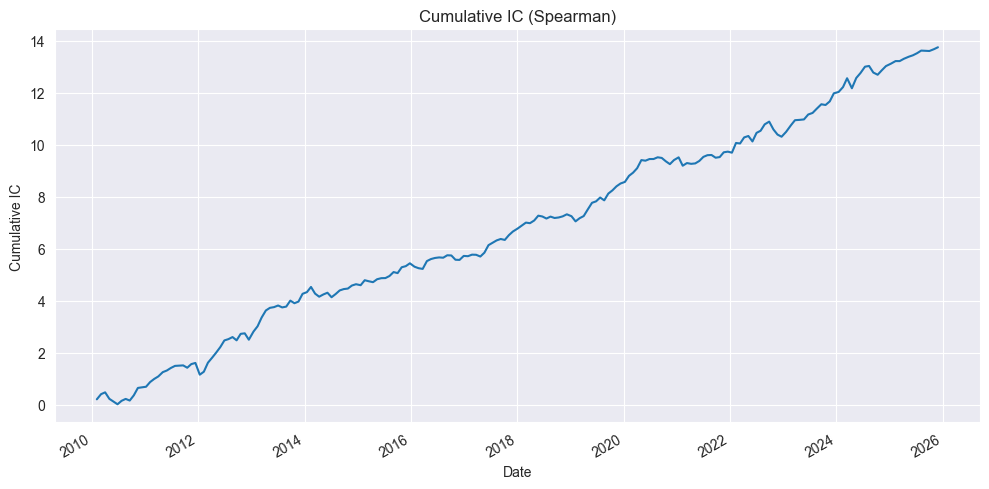

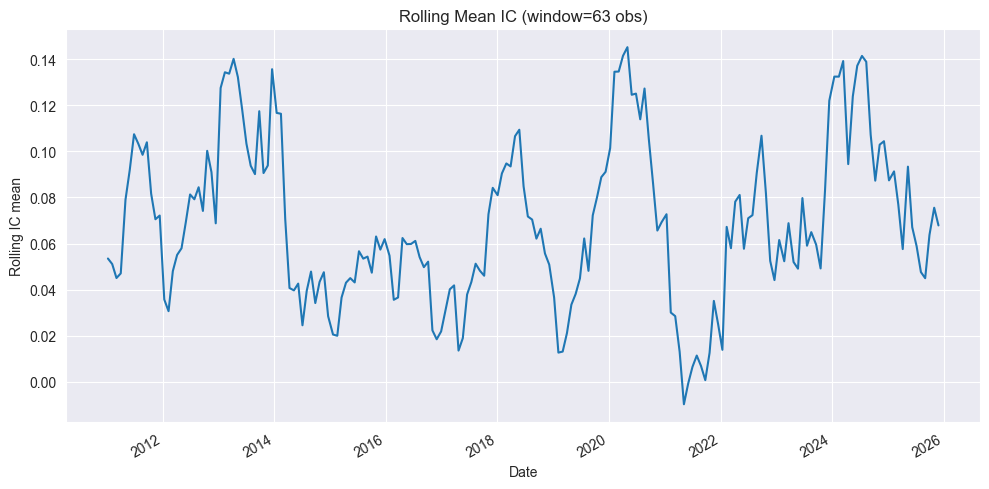

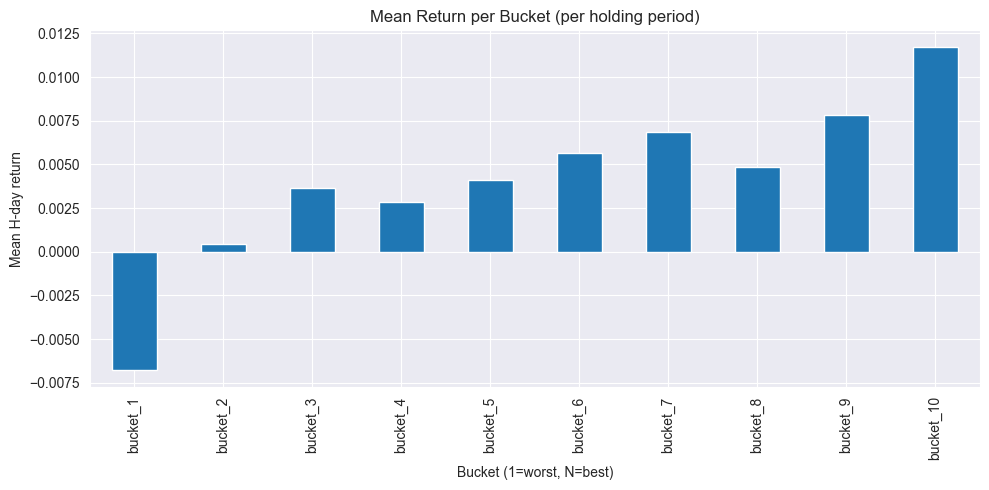

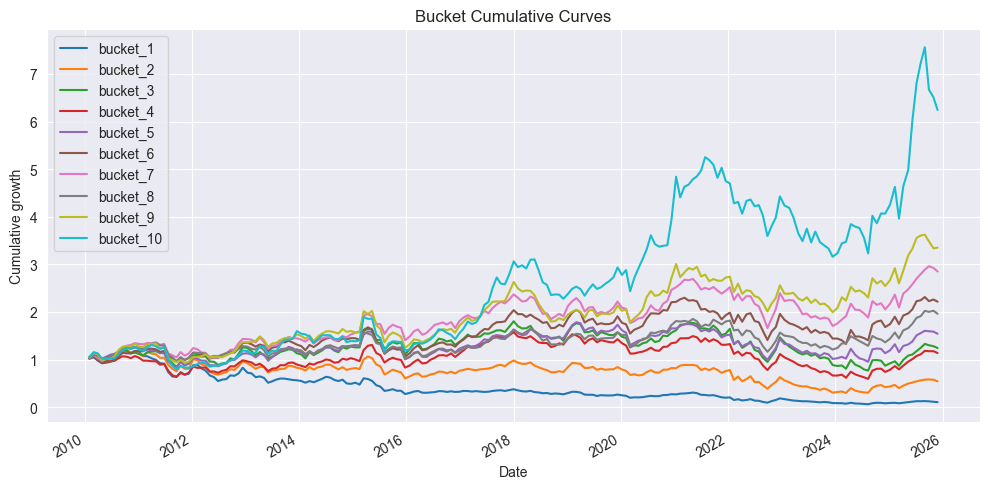

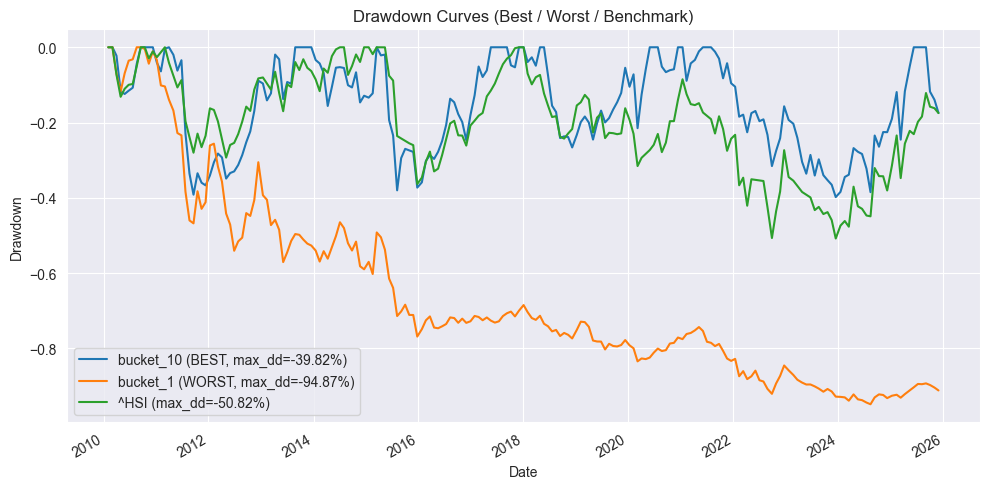

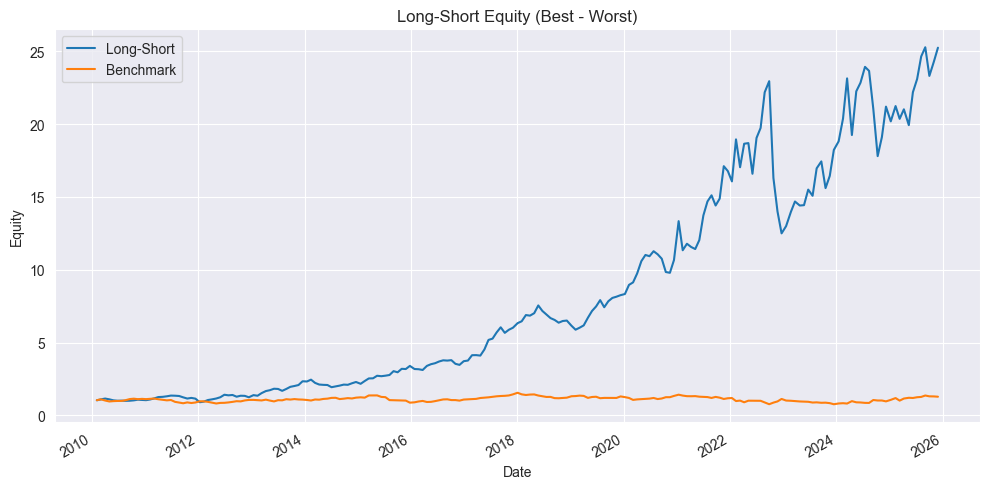

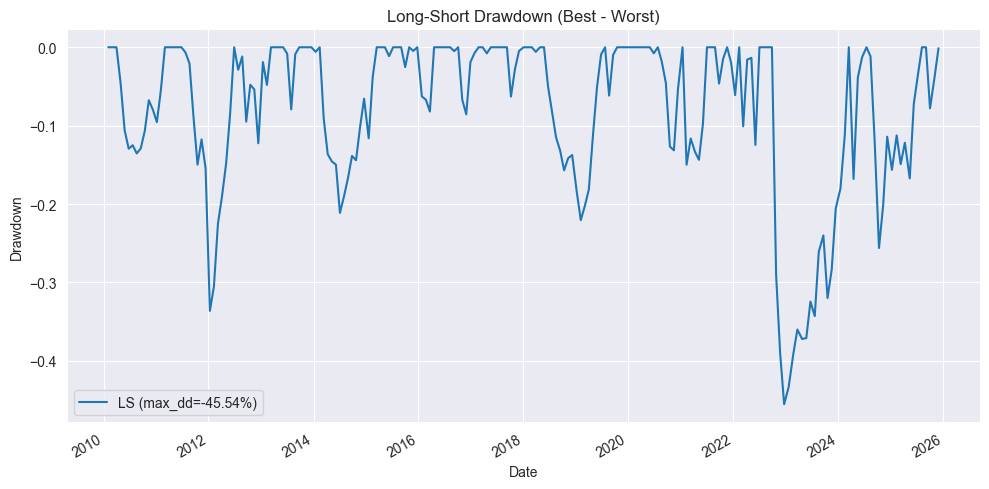

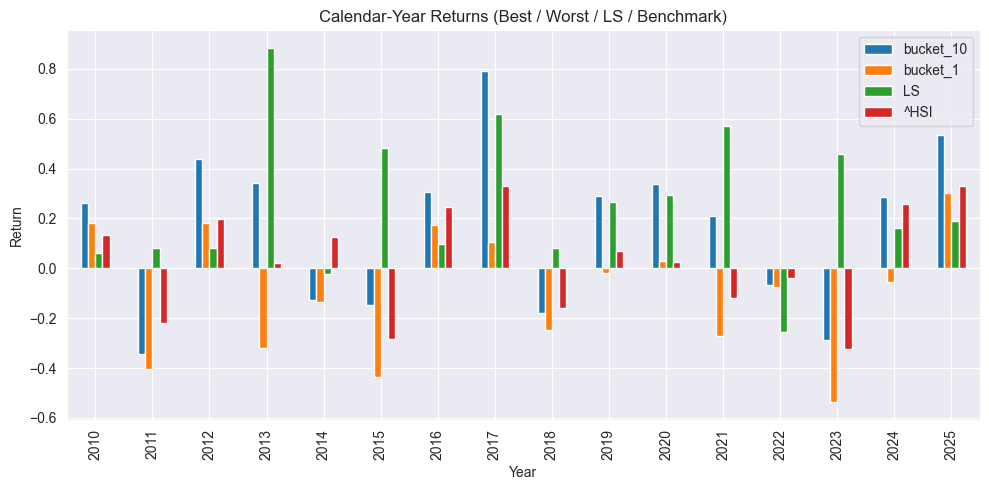

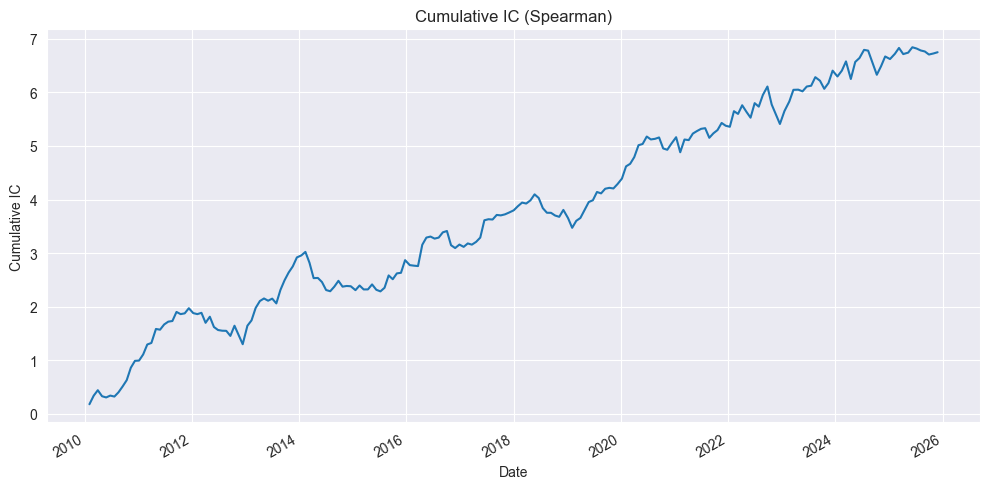

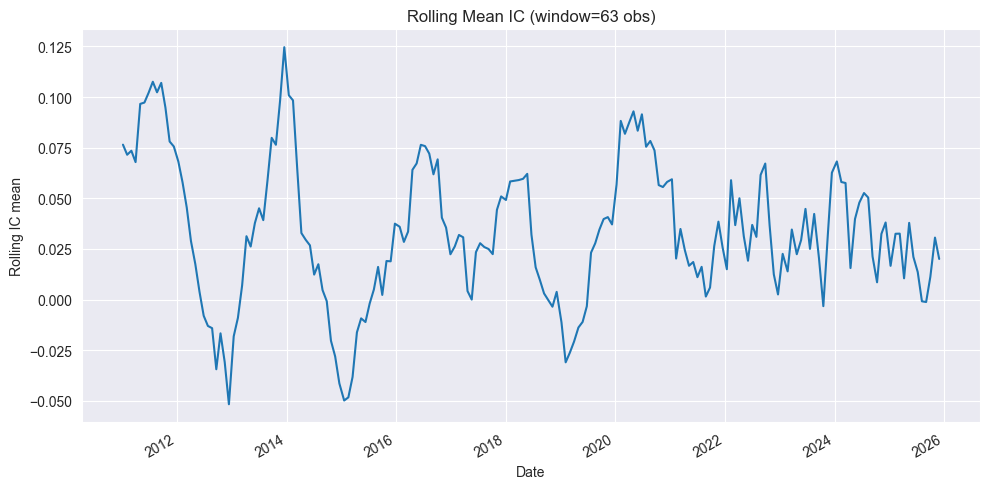

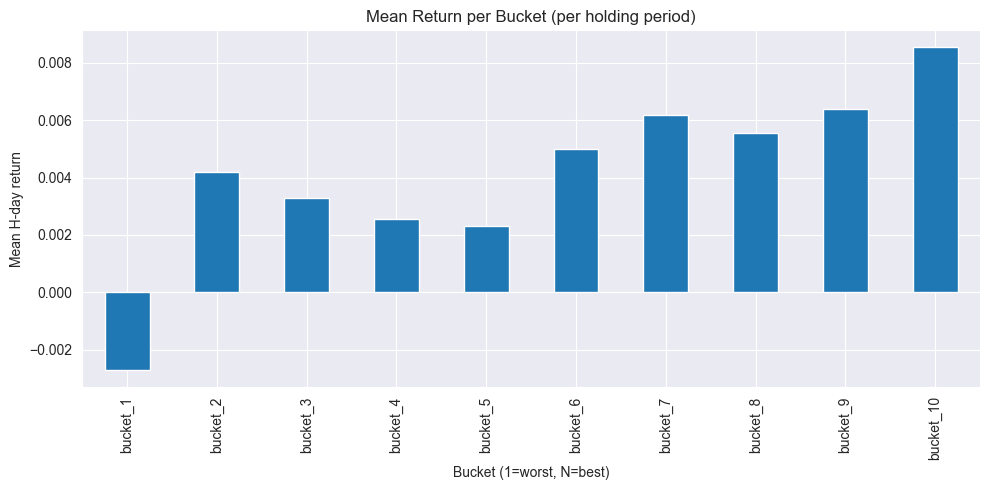

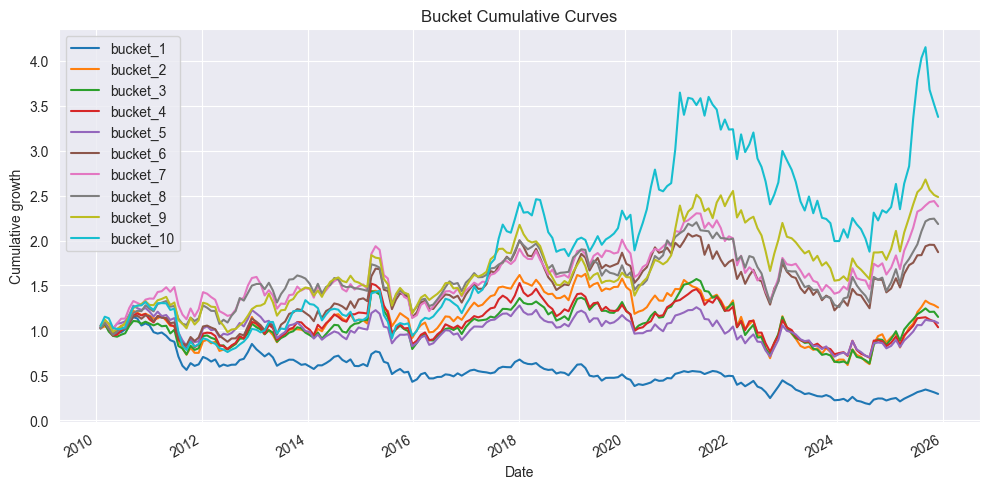

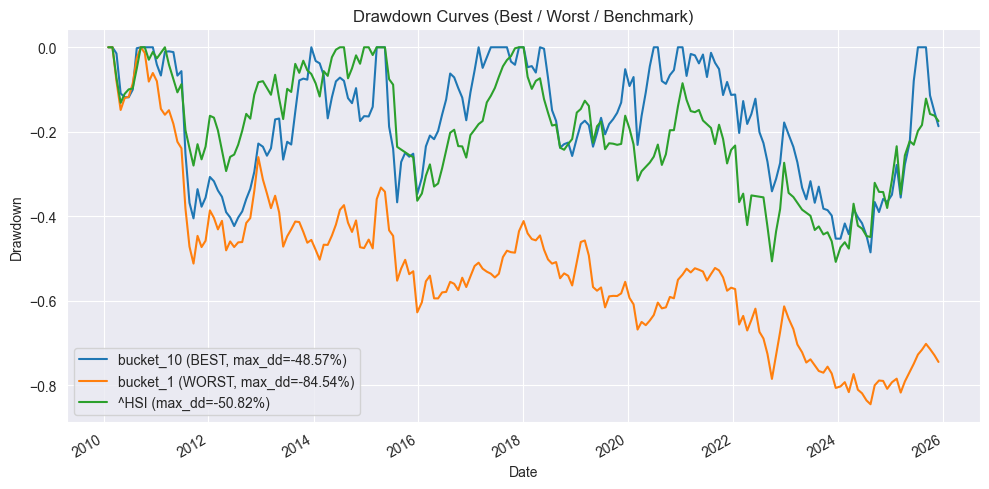

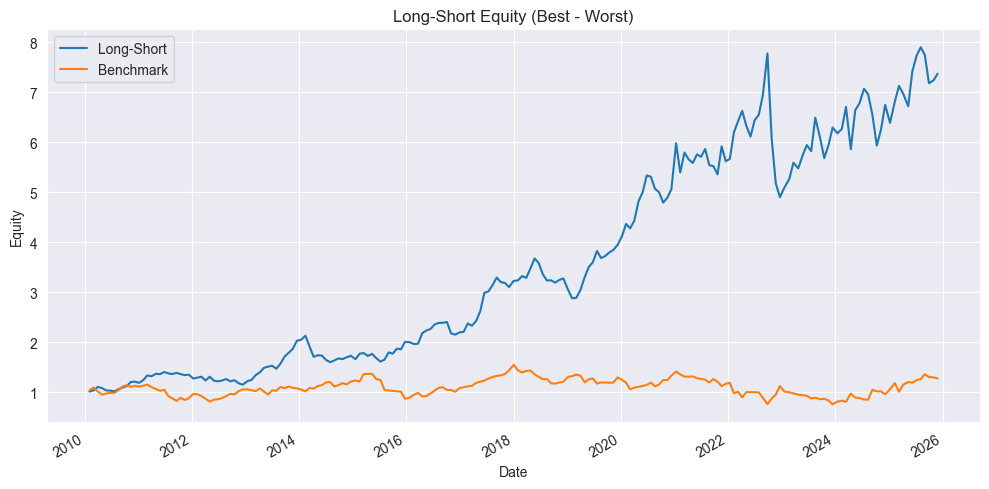

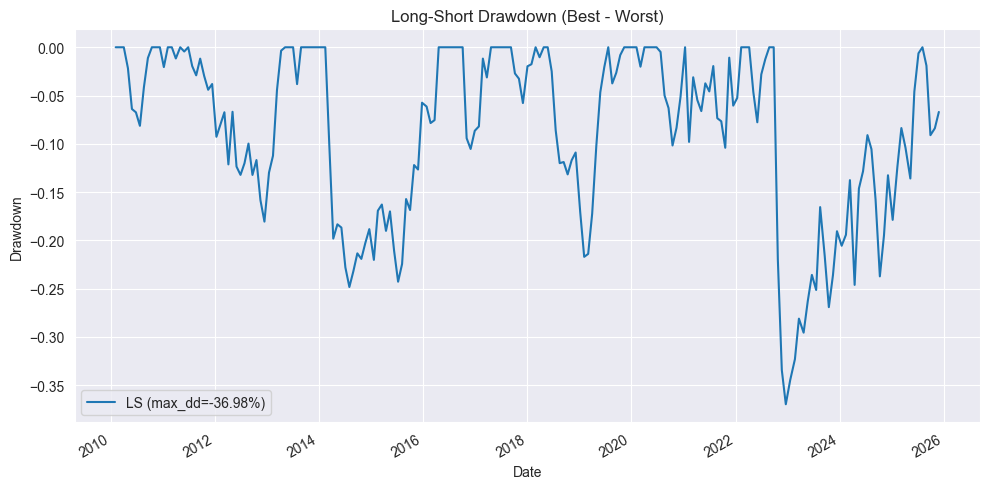

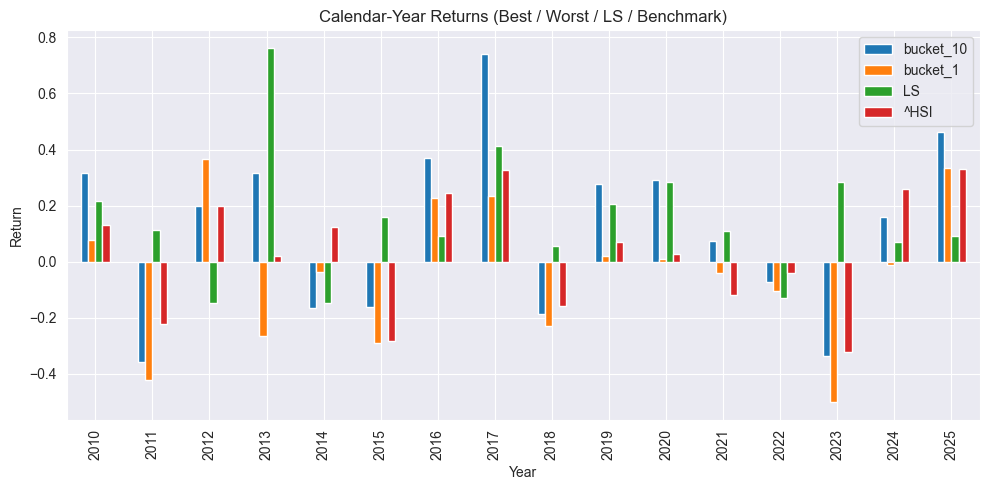

In [75]:
from qresearch.signals.registry import compute_signal
from qresearch.backtest.buckets import make_tearsheet


sig = compute_signal(md, name="trend_annret_r2", lookback=252, ann_factor=252, skip=21)
sig = sig.reindex(index=md.close.index, columns=md.close.columns)

neu_sector = neutralize_sector(sig, sector_df)
neu_sec_and_mktcap = neutralize_sector_and_mcap_fwl(sig, hsci_sector_map['sector'], hsci_market_cap, universe_eligible)


rep = make_tearsheet(
    md=md,
    signal=sig,
    H=20,
    n_buckets=10,
    entry_mode="next_close",
    min_assets_ic=50,
    plot=True,
    benchmark_price=hsi,
    benchmark_name="^HSI",
    universe_eligible=universe_eligible,  # critical
)

rep_neu = make_tearsheet(
    md=md,
    signal=neu_sec_and_mktcap,
    H=20,
    n_buckets=10,
    entry_mode="next_close",
    min_assets_ic=50,
    plot=True,
    benchmark_price=hsi,
    benchmark_name="^HSI",
    universe_eligible=universe_eligible,  # critical
)


In [36]:
from qresearch.signals.signals_sweep import *

test_ma_diff = [
    # ('ma_diff', {"lookback": 63, "skip": 0}),
    # ('ma_diff', {"lookback": 120, "skip": 12}),
    # ('ma_diff', {"lookback": 200, "skip": 0}),
    ('ma_diff', {"lookback": 250, "skip": 21}),
]

test_mom_ret = [
    # ("mom_ret", {"lookback": 63, 'skip': 0}),
    # ("mom_ret", {"lookback": 126, "skip": 12}),
    ("mom_12_1", {"lookback": 252, "skip": 21}),
]

test_ohlc_mom = [
    # ('intraday_mom', {"lookback": 10, 'sign': -1}),
    # ("on_minus_id", {"lookback": 126}),
    # ("overnight_mom", {"lookback": 126}),
    # ('intraday_mom', {"lookback": 126, 'sign': -1}),
    # ("on_minus_id", {"lookback": 252}),
    # ("overnight_mom", {"lookback": 252}),
    ('intraday_mom', {"lookback": 252, 'sign': 1}),
]

test_trend_annret_r2 = [
    ("trend_annret_r2", {"lookback": 126, "ann_factor": 252, 'skip': 21}),
    ("trend_annret_r2", {"lookback": 252, "ann_factor": 252, 'skip': 21}),
]

vol_default = {"lookback": 63, "sign": -1}
test_vol = [
    ('vol_std_3M', vol_default),
    ('vol_downshadow_std_3M', vol_default),
    ('vol_upshadow_std_3M', vol_default),
    ('vol_highlow_std_3M', vol_default),
    ('vol_highlow_avg_3M', vol_default),
    ('vol_w_upshadow_std_3M', vol_default),
    ('vol_w_downshadow_std_3M', vol_default)
]
tests = test_vol

# tests = test_ma_diff + test_mom_ret + test_trend_annret_r2 + test_ohlc_mom


# test_vol = [
#     ('volume_breakout', {}),
#     ('vol_price_combination', {}),
#     ('vwap_dev_x_volratio_x_mom', {}),
#     ('fourline_open_score', {})
# ]
# tests = test_vol

# test_liq = [
#     ('liq_vstd_3M', None),
#     # ('liq_amihud_avg_3M', {'sign': -1}),
#     ('liq_amihud_std_3M', {'sign': -1}),
#     # ('liq_turn_avg_3M', None),
#     # ('liq_turn_std_3M', None)
# 
# ]
# 
# tests = test_liq

tests = [('size', {'sign': 1})]

In [144]:
cfg = SignalTestConfig(
    H=20,
    n_buckets=10,
    entry_mode="next_close",
    min_assets_ic=50,
)

df, rep_map = sweep_signals(
    md=md,
    tests=tests,
    cfg=cfg,
    universe_eligible=universe_eligible,  # pass once
    keep_rep=True,
)

df

## IC Corr

In [145]:
def ic_corr_matrix(
    IC: pd.DataFrame,
    method: str = "pearson",     # "pearson" or "spearman"
    min_obs: int = 60,           # minimum overlapping days per pair
) -> pd.DataFrame:
    ic = IC.copy()
    ic.index = pd.to_datetime(ic.index)
    ic = ic.sort_index()

    cols = list(ic.columns)
    out = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for i, c1 in enumerate(cols):
        s1 = ic[c1]
        for j, c2 in enumerate(cols):
            if j < i:
                continue
            s2 = ic[c2]
            xy = pd.concat([s1, s2], axis=1).dropna()
            if len(xy) < min_obs:
                val = np.nan
            else:
                val = xy.iloc[:, 0].corr(xy.iloc[:, 1], method=method)
            out.loc[c1, c2] = val
            out.loc[c2, c1] = val

    np.fill_diagonal(out.values, 1.0)
    return out


def ic_corr_top_pairs(
    corr_mat: pd.DataFrame,
    top_n: int = 30,
    abs_sort: bool = True,
) -> pd.DataFrame:
    c = corr_mat.copy()

    # upper triangle only
    mask = np.triu(np.ones(c.shape, dtype=bool), k=1)
    pairs = (
        c.where(mask)
         .stack()
         .rename("corr")
         .reset_index()
         .rename(columns={"level_0": "f1", "level_1": "f2"})
    )

    if abs_sort:
        pairs["abs_corr"] = pairs["corr"].abs()
        pairs = pairs.sort_values("abs_corr", ascending=False).drop(columns=["abs_corr"])
    else:
        pairs = pairs.sort_values("corr", ascending=False)

    return pairs.head(top_n).reset_index(drop=True)


def build_ic_df_from_rep_map(rep_map: dict[str, dict], ic_series_key: str = "ic_series") -> pd.DataFrame:
    """
    rep_map: {signal_key: rep}
    rep[ic_series_key] should be a pd.Series indexed by date (daily IC)
    """
    series = {}
    for k, rep in rep_map.items():
        s = rep.get(ic_series_key)
        if s is None:
            raise KeyError(f"rep for {k} missing '{ic_series_key}'. Available keys: {list(rep.keys())[:20]}")
        series[k] = pd.Series(s).rename(k)

    IC = pd.concat(series.values(), axis=1)
    IC.index = pd.to_datetime(IC.index)
    return IC.sort_index()

trend_annret_r2(ann_factor=252,lookback=252,skip=21)  \
trend_annret_r2(ann_factor=252,lookback=252,ski...                                           1.000000      
vol_highlow_std_3M()                                                                         0.209931      
liq_amihud_std_3M(sign=-1)                                                                   0.085384      

                                                    vol_highlow_std_3M()  \
trend_annret_r2(ann_factor=252,lookback=252,ski...              0.209931   
vol_highlow_std_3M()                                            1.000000   
liq_amihud_std_3M(sign=-1)                                      0.517461   

                                                    liq_amihud_std_3M(sign=-1)  
trend_annret_r2(ann_factor=252,lookback=252,ski...                    0.085384  
vol_highlow_std_3M()                                                  0.517461  
liq_amihud_std_3M(sign=-1)                                            1.000000

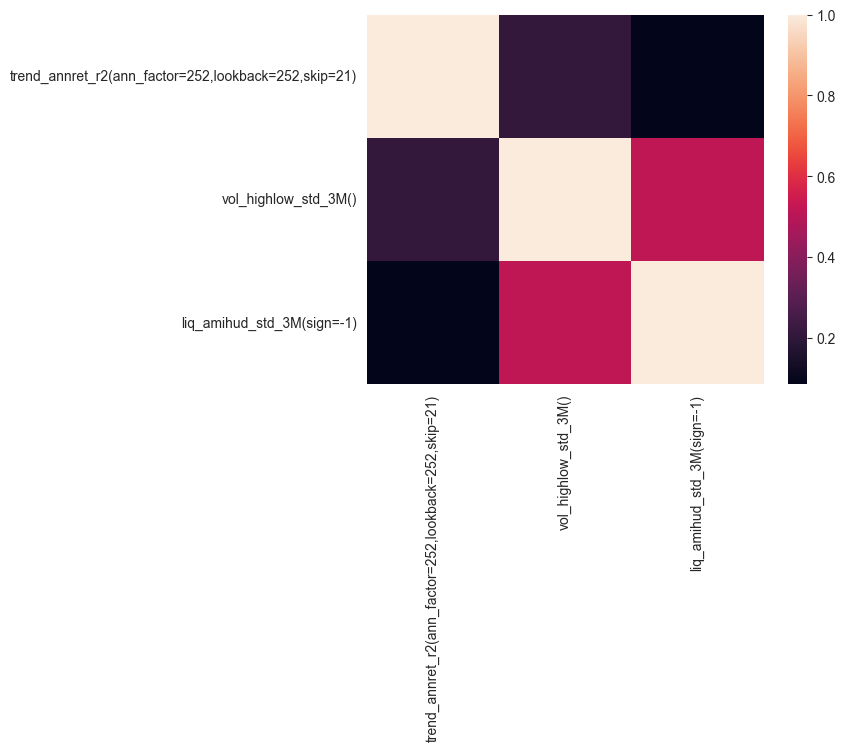

In [147]:
good_signals = [
    ("trend_annret_r2", {"lookback": 252, "ann_factor": 252, 'skip': 21}),
    ('vol_highlow_std_3M', {}),
    ('liq_amihud_std_3M', {'sign': -1}),
]

df, rep_map = sweep_signals(
    md=md,
    tests=good_signals,
    cfg=cfg,
    universe_eligible=universe_eligible,  # pass once
    keep_rep=True,
    benchmark_name='^HSI',
    benchmark_price=hsi,
)

IC = build_ic_df_from_rep_map(rep_map, ic_series_key="ic")  # adjust key if needed

corr = ic_corr_matrix(IC, method="pearson", min_obs=60)

sns.heatmap(corr)
corr

In [149]:
ic_corr_top_pairs(corr, abs_sort=True)['corr'].mean()

np.float64(0.27092517786408277)

## Diagnose

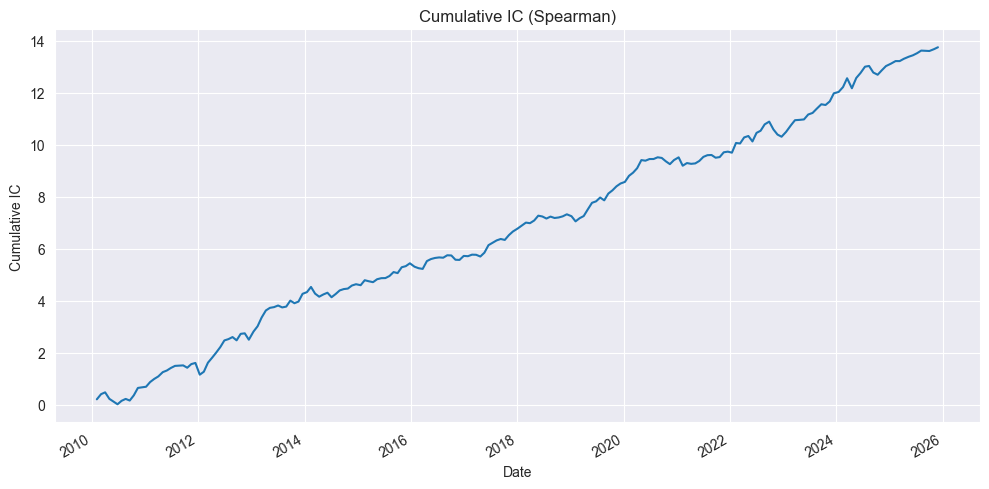

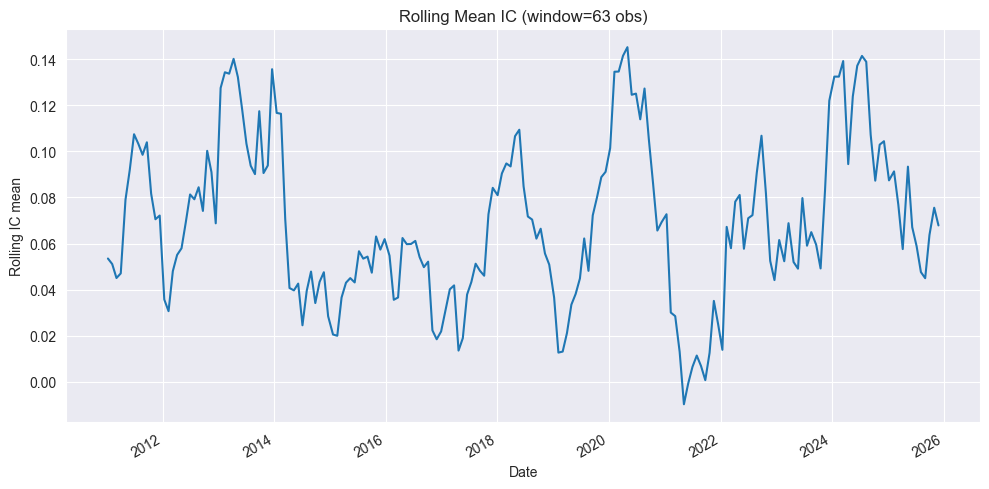

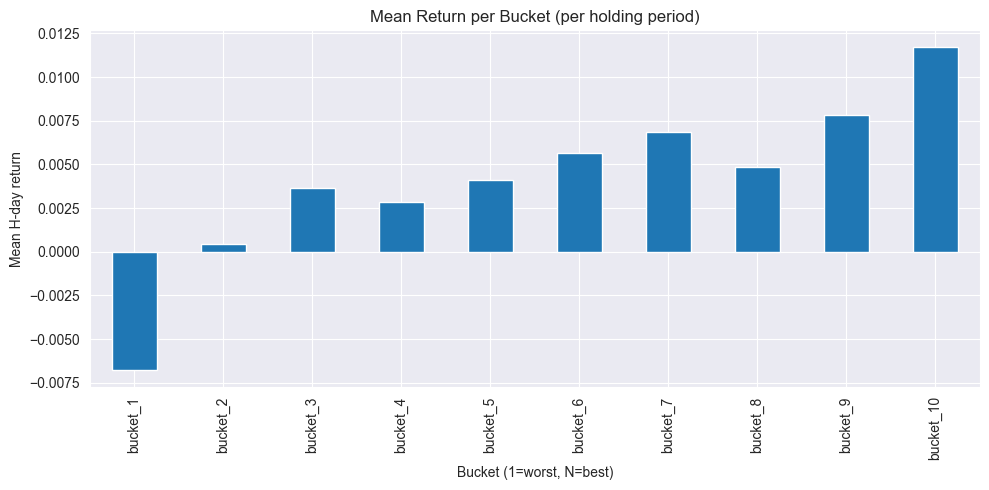

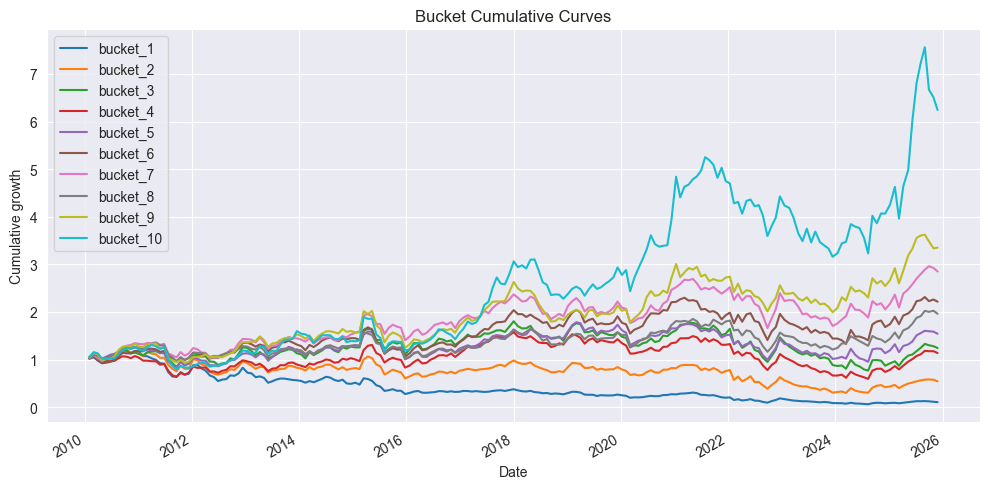

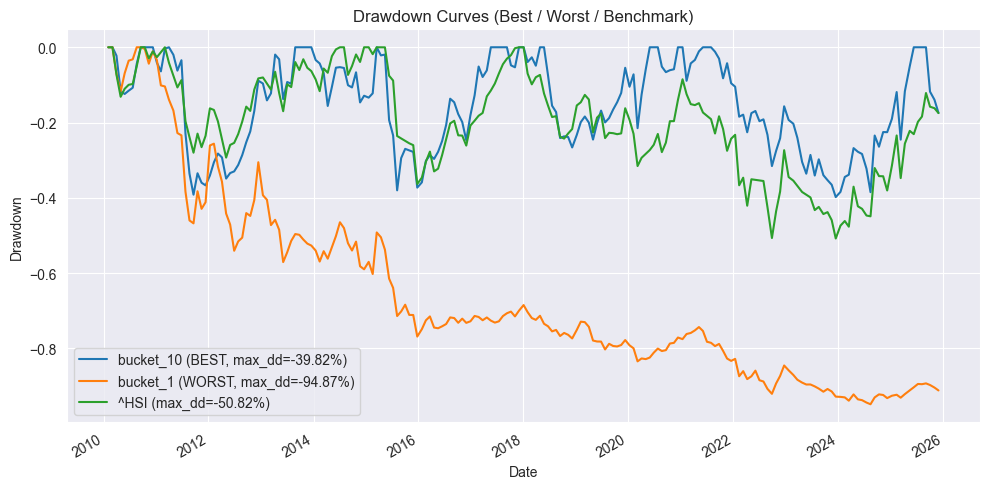

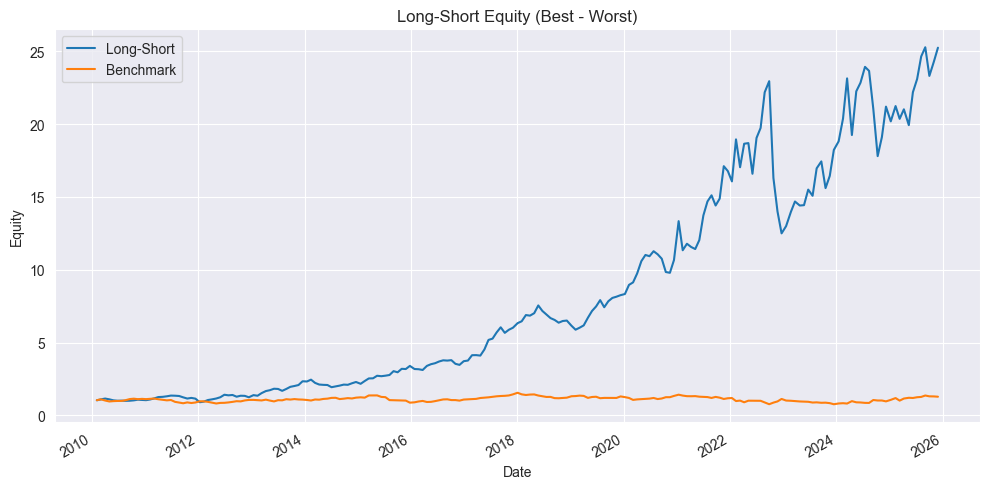

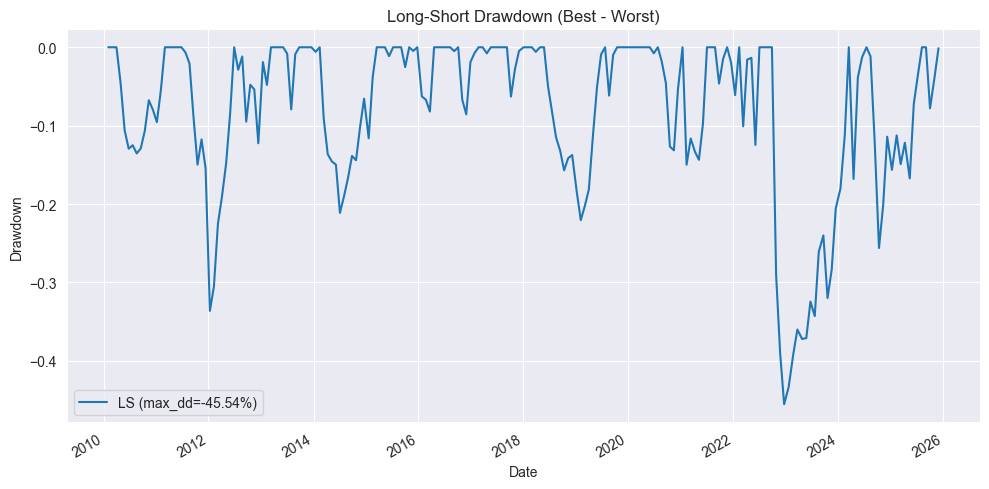

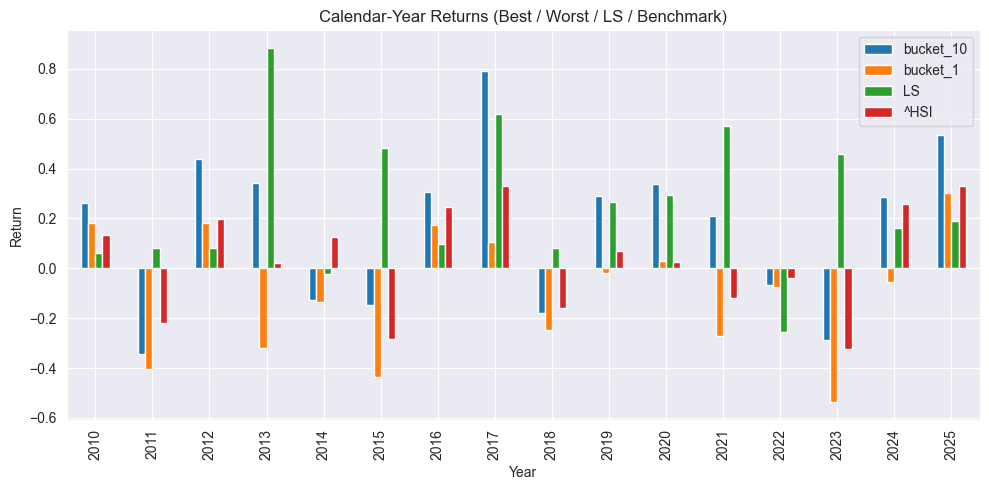

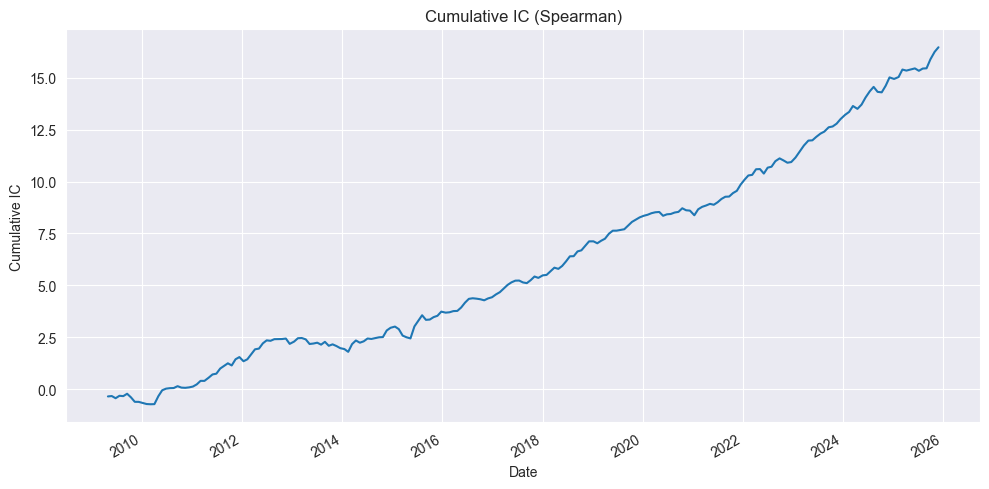

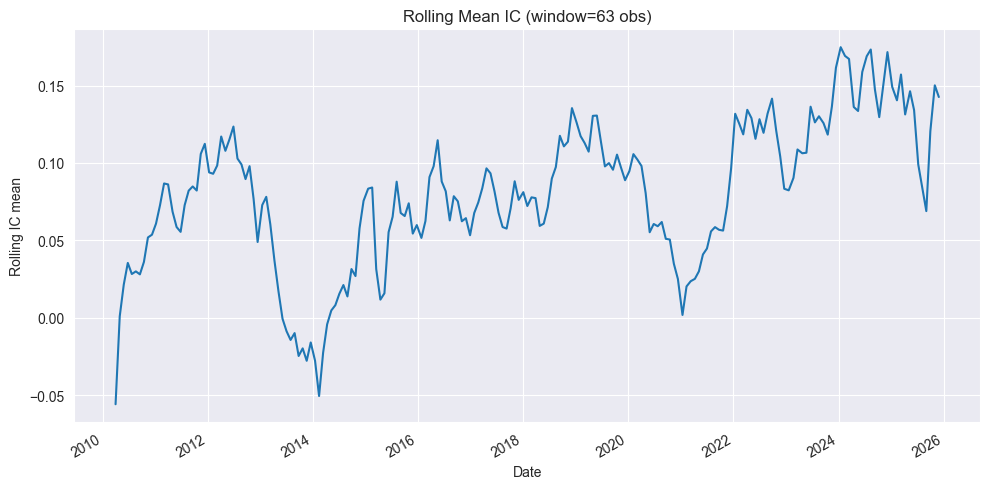

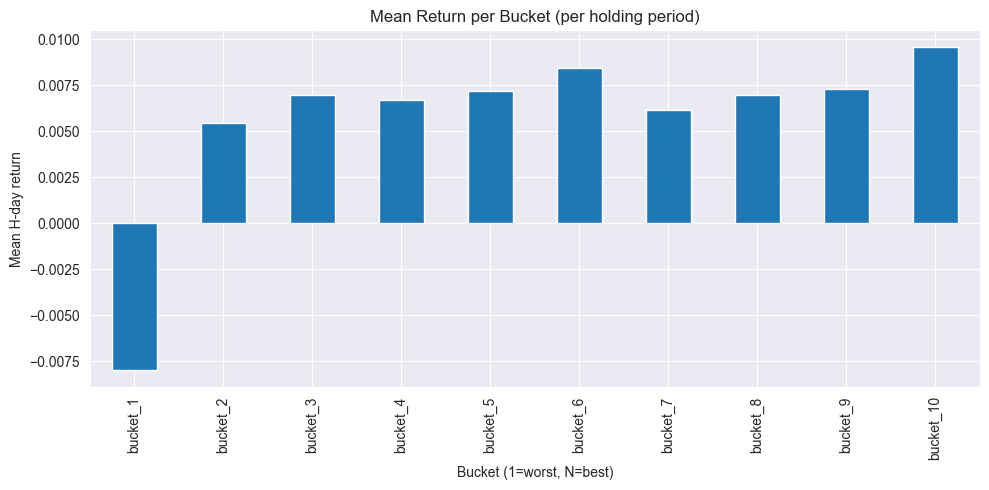

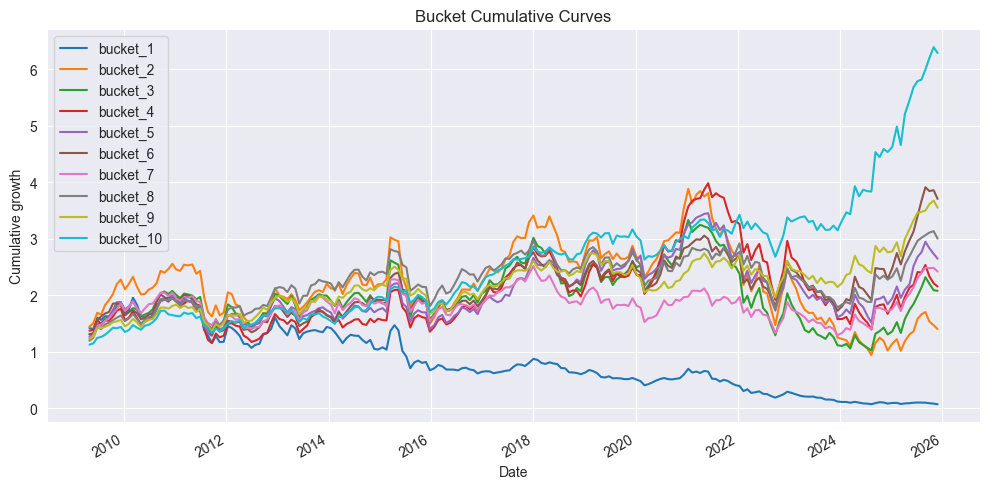

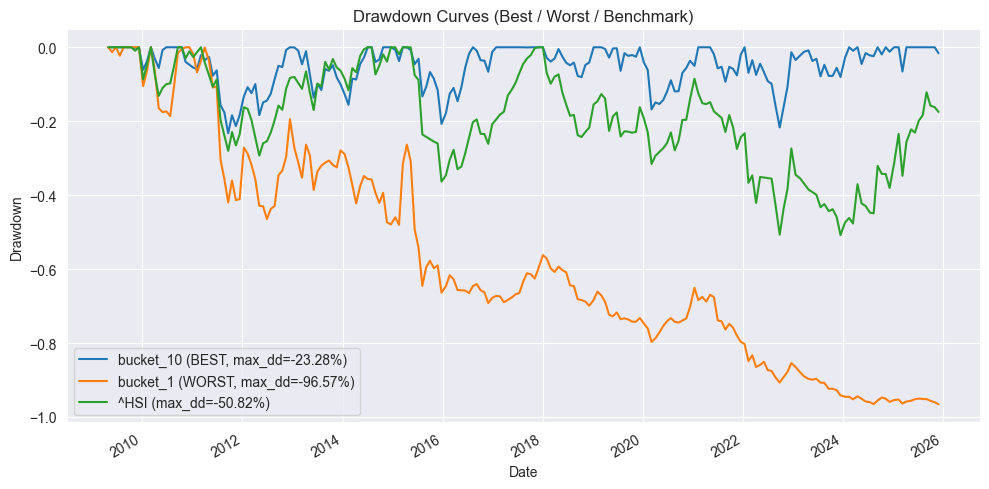

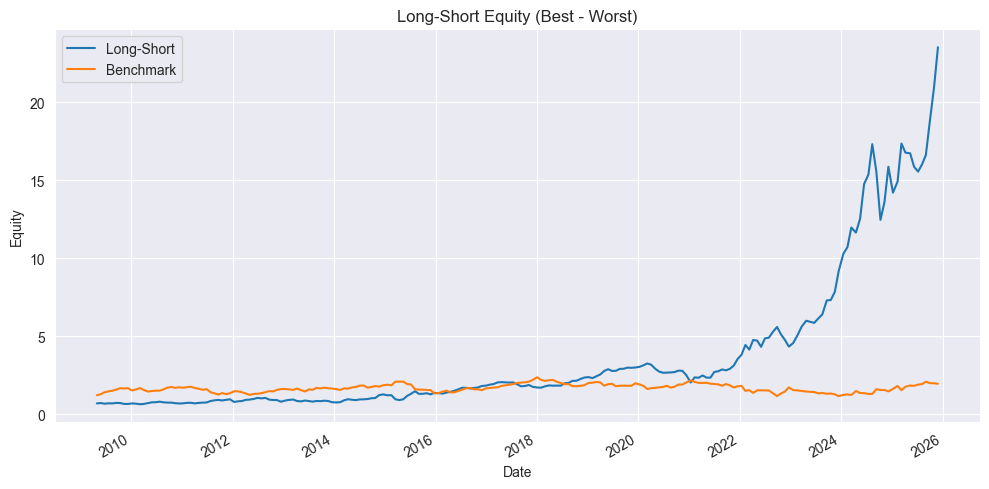

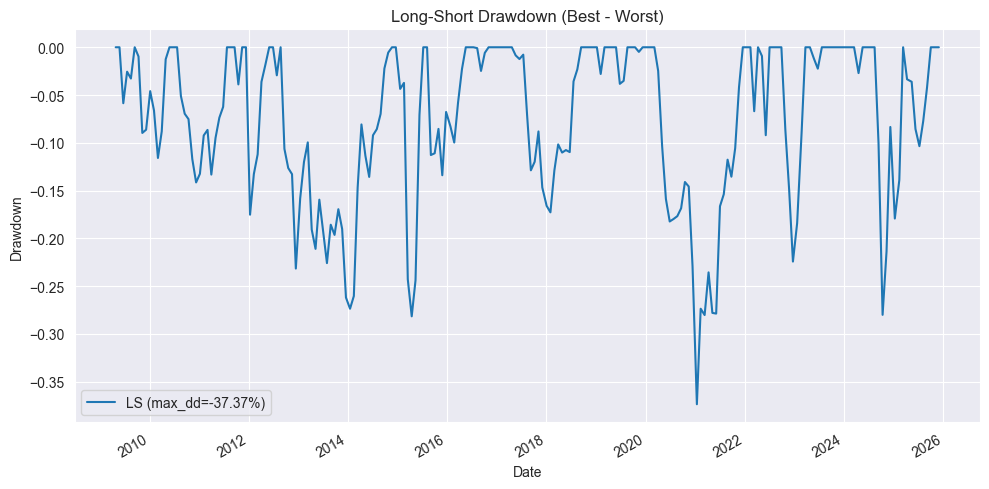

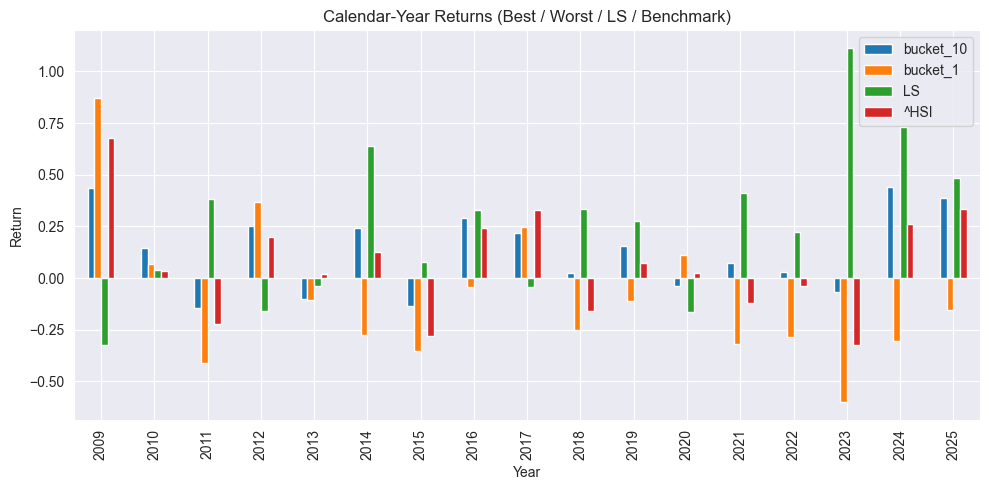

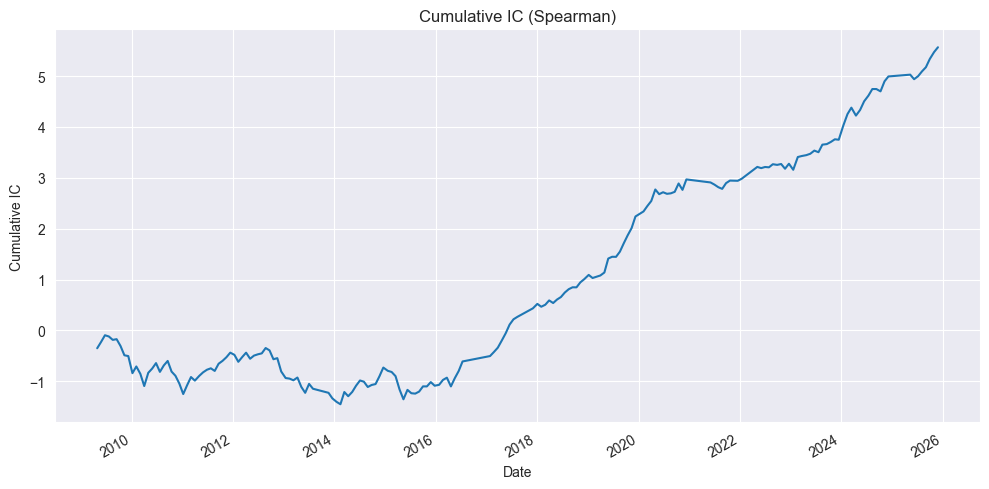

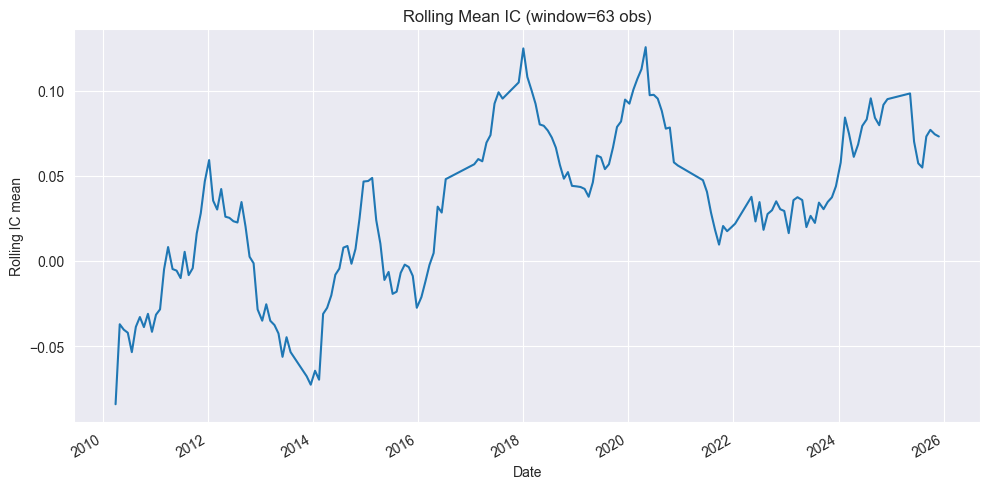

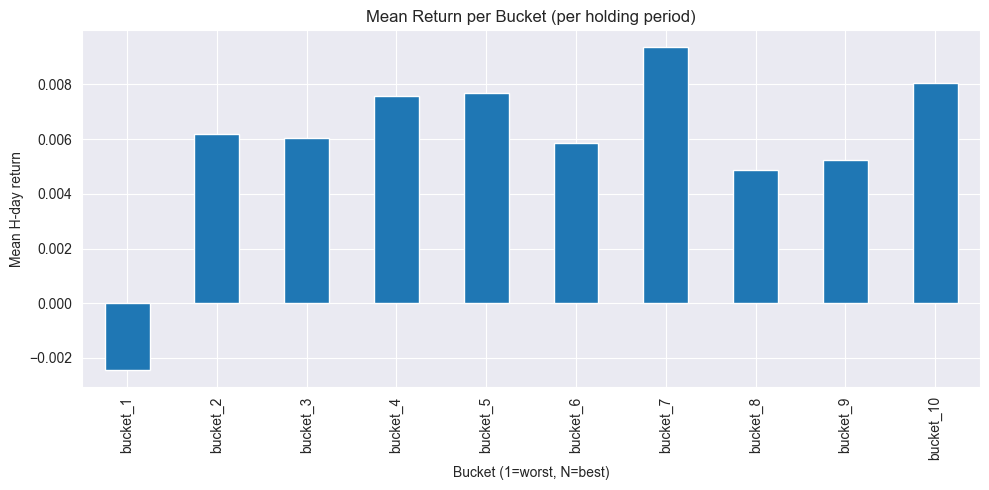

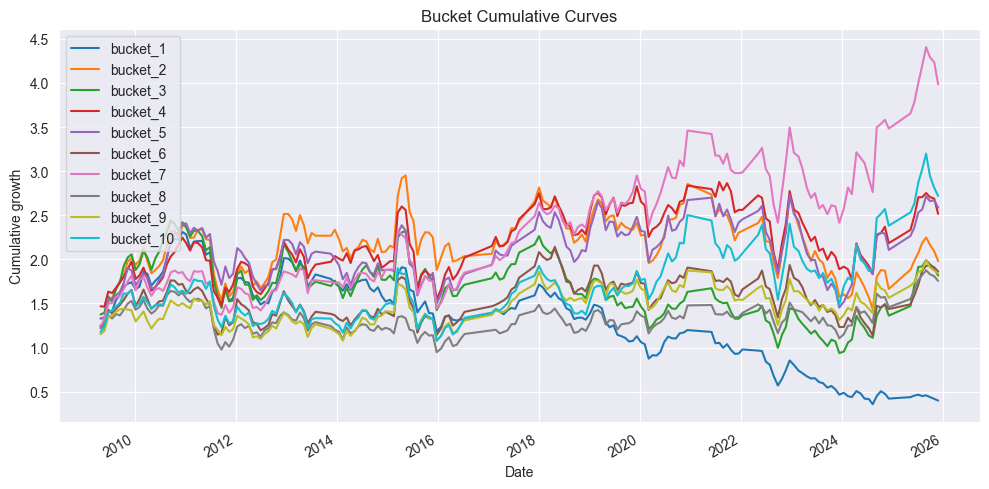

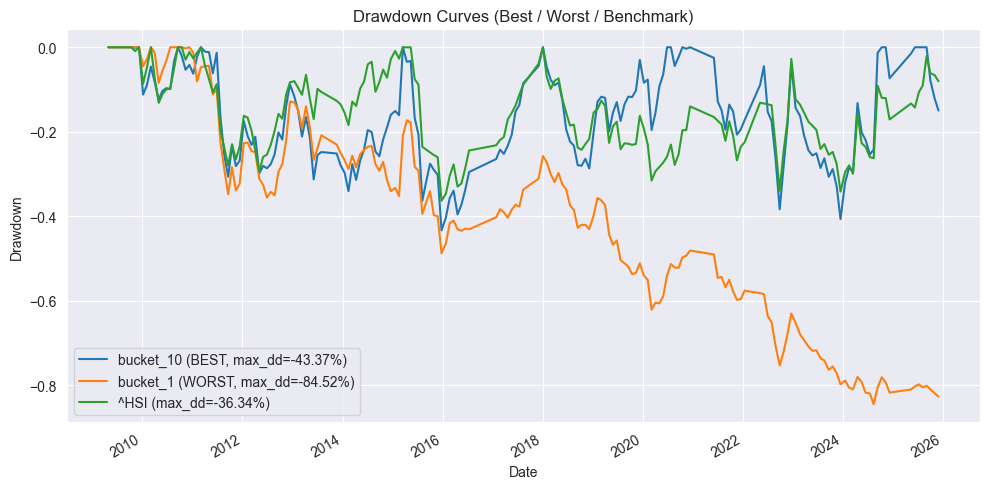

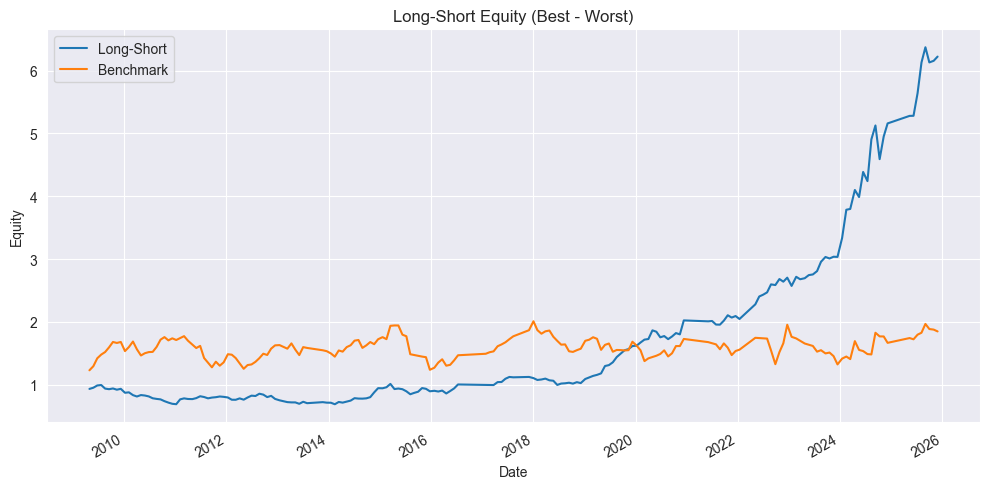

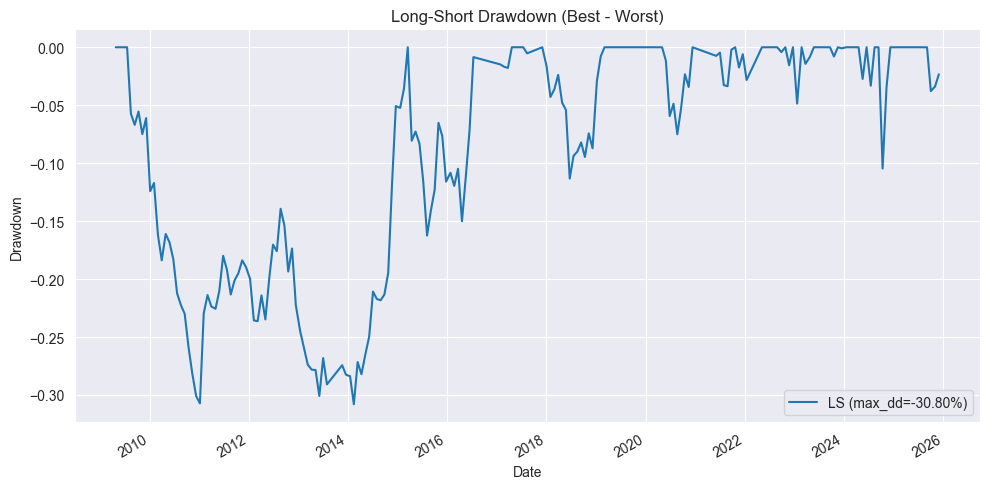

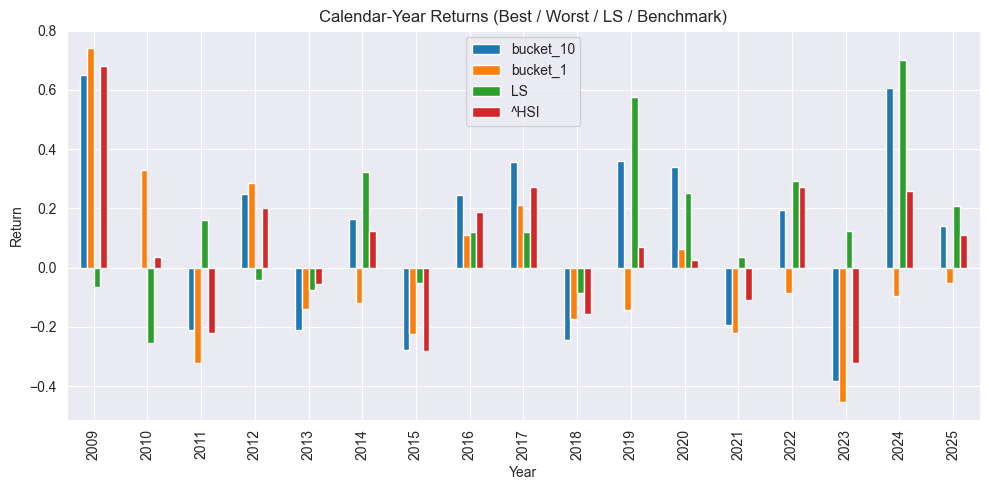

In [55]:
results = {}

for signal, params in good_signals:
    sig = compute_signal(md, name=signal, **params)
    sig = sig.reindex(index=md.close.index, columns=md.close.columns)
    
    neu_sec_and_mktcap = neutralize_sector_and_mcap_fwl(sig, hsci_sector_map['sector'], hsci_market_cap, universe_eligible)
    
    rep = make_tearsheet(
        md=md,
        signal=sig,
        H=20,
        n_buckets=10,
        entry_mode="next_close",
        min_assets_ic=50,
        plot=True,
        benchmark_price=hsi,
        benchmark_name="^HSI",
        universe_eligible=universe_eligible,  # critical
    )
    
    rep_neu = make_tearsheet(
        md=md,
        signal=neu_sec_and_mktcap,
        H=20,
        n_buckets=10,
        entry_mode="next_close",
        min_assets_ic=50,
        plot=False,
        benchmark_price=hsi,
        benchmark_name="^HSI",
        universe_eligible=universe_eligible,  # critical
    )
    
    results[f'{signal} Neutralised'] = rep_neu
    results[f'{signal}'] = rep

In [49]:
for signal_k in results:
    print(f'\n{signal_k}')
    for k in results[signal_k]:
        if isinstance(results[signal_k][k], pd.DataFrame):
            continue
        elif isinstance(results[signal_k][k], pd.Series) and results[signal_k][k].shape[0] > 30:
            continue
        print(f'{k}: {results[signal_k][k]}')


trend_annret_r2 Neutralised
meta: {'H': 20, 'n_buckets': 10, 'entry_mode': 'next_close', 'freq_per_year': 12.6, 'rolling_window_obs': 13, 'universe_size': 934, 'n_rebalance_obs': 203, 'bucket_convention': 'bucket_1 = worst, bucket_n = best'}
ic_stats: {'ic_mean': 0.03325354061201703, 'ic_std': 0.1294115703901235, 'icir': 0.2569595632892103, 'hit_rate': 0.6108374384236454, 'n_obs': 203}
monotonic_spearman_bucket_vs_mean: 0.8666666666666665
best_bucket: bucket_10
worst_bucket: bucket_1
ls_perf: {'ann_return_geo': 0.13202958199124337, 'ann_vol': 0.18721755723593797, 'sharpe': 0.7601014216525721, 'max_dd': -0.36983320587251833, 'n_obs': 203}
ls_yearly: 2010    0.216379
2011    0.113625
2012   -0.148180
2013    0.761674
2014   -0.147517
2015    0.161360
2016    0.093265
2017    0.411856
2018    0.055576
2019    0.204210
2020    0.282682
2021    0.110352
2022   -0.127879
2023    0.284464
2024    0.071605
2025    0.092330
Name: LS_best_minus_worst, dtype: float64
benchmark_perf: {'ann_return

In [50]:
for signal_k in results:
    print(f'\n{signal_k}')
    print(results[signal_k].keys())
    # for k in results[signal_k]:
    #     print(results[signal_k][k])
    break


trend_annret_r2 Neutralised
dict_keys(['meta', 'bucket_ret', 'bucket_labels', 'ret_fwd', 'coverage', 'n_valid', 'ic', 'ic_stats', 'ic_roll', 'bucket_summary', 'monotonic_spearman_bucket_vs_mean', 'best_bucket', 'worst_bucket', 'turnover_best', 'turnover_worst', 'ls_ret', 'ls_perf', 'ls_eq', 'ls_dd', 'ls_yearly', 'benchmark_ret', 'benchmark_perf', 'benchmark_eq', 'benchmark_dd', 'benchmark_yearly'])


Long active sector weights (mean):
sec
Technology                0.034950
Basic Materials           0.023533
Consumer Cyclical         0.020599
Communication Services    0.014022
Utilities                 0.011420
Energy                    0.004169
UNKOWN                    0.003040
Healthcare               -0.001186
Consumer Defensive       -0.002639
Industrials              -0.011616
dtype: float64

Short active sector weights (mean):
sec
Consumer Cyclical         0.032426
Healthcare                0.030998
Energy                    0.028420
Technology                0.024683
Consumer Defensive        0.012902
Basic Materials           0.010622
Communication Services    0.005826
UNKOWN                    0.005623
Industrials              -0.015742
Utilities                -0.016601
dtype: float64

Size exposure (ln mcap) mean time series head:
group            Long      Short   Universe
date                                       
2010-02-03  23.940328  24.509420  24.161657
2010-03-04

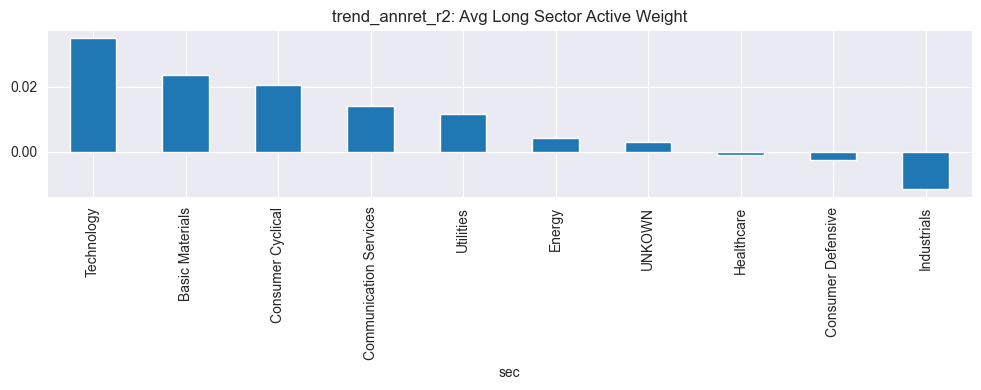

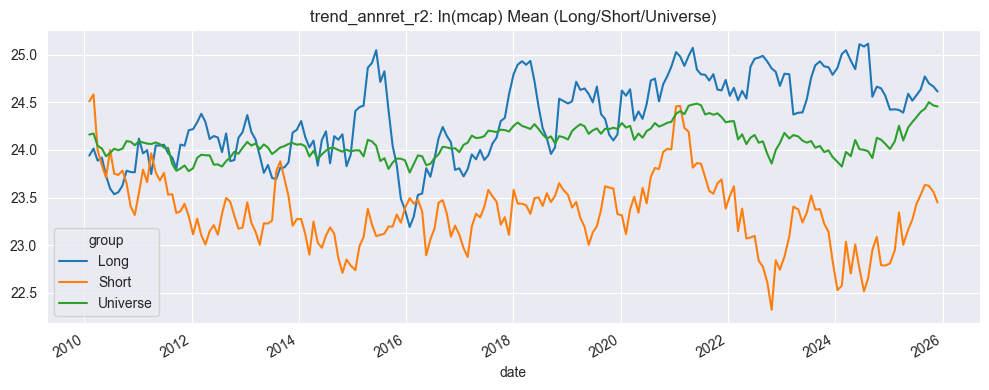

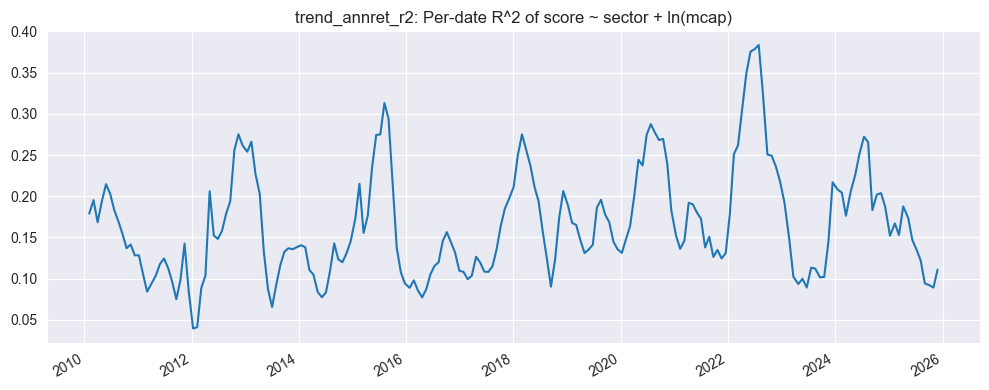

In [132]:
# ============================================================
# Exposure diagnostics for a given tearsheet rep (raw or neutralised)
# A) Sector exposure: Long/Short weights vs Universe weights (time series + averages)
# B) Size exposure: ln(mcap) distribution of Long/Short vs Universe (time series + summaries)
# C) Explained variance: per-date R^2 of score ~ sector + ln(mcap)
#
# Inputs you already have:
# - rep: output of make_tearsheet(...)  [optional, used for dates alignment]
# - signal_scores: pd.DataFrame (date x ticker)  # the raw factor scores at each date
# - hsci_sector_map['sector']: pd.Series (ticker -> sector)
# - hsci_market_cap: pd.DataFrame (date x ticker)  # NOT logged, approx mcap
# - universe_eligible: pd.DataFrame (date x ticker) bool  # your eligible mask
#
# Notes:
# - This is designed to be used on the *rebalance dates* only.
# - It assumes top/bottom selection is by cross-sectional score on each rebalance date.
# - It uses equal-weight within Long and Short legs (consistent with typical L/S decile portfolios).
# ============================================================

import numpy as np
import pandas as pd

# ----------------------------
# Utilities
# ----------------------------
def sector_series_to_df(sector: pd.Series, dates, tickers) -> pd.DataFrame:
    """Broadcast ticker->sector to date x ticker"""
    s = sector.reindex(tickers)
    return pd.DataFrame(np.tile(s.to_numpy(), (len(dates), 1)), index=dates, columns=tickers)

def to_log_mcap(mcap: pd.DataFrame) -> pd.DataFrame:
    x = mcap.copy()
    x = x.where(x > 0)
    return np.log(x)

def get_rebalance_dates_from_rep(rep: dict) -> pd.DatetimeIndex:
    """
    Your rep has ls_ret indexed by rebalance dates (period returns).
    These are good rebalance anchors for exposure snapshots.
    """
    if "ls_ret" in rep and rep["ls_ret"] is not None:
        idx = rep["ls_ret"].index
        return pd.to_datetime(idx)
    raise KeyError("rep must contain 'ls_ret' to infer rebalance dates")

def _cs_rank(s: pd.Series) -> pd.Series:
    """Cross-sectional rank in [0,1], higher is better."""
    return s.rank(pct=True, method="average")

def select_long_short(
    scores_row: pd.Series,
    elig_row: pd.Series,
    top_frac: float = 0.10,
    bottom_frac: float = 0.10,
):
    """Return boolean masks for long and short selections."""
    s = scores_row.copy()
    e = elig_row.astype(bool)
    s = s.where(e)

    s = s.dropna()
    if len(s) < 2:
        return None, None

    n = len(s)
    n_long = max(1, int(np.floor(top_frac * n)))
    n_short = max(1, int(np.floor(bottom_frac * n)))

    # sort
    s_sorted = s.sort_values(ascending=False)

    long_names = s_sorted.index[:n_long]
    short_names = s_sorted.index[-n_short:]

    long_mask = pd.Series(False, index=elig_row.index)
    short_mask = pd.Series(False, index=elig_row.index)
    long_mask.loc[long_names] = True
    short_mask.loc[short_names] = True

    return long_mask, short_mask

def equal_weights(mask: pd.Series) -> pd.Series:
    """Equal weights over True entries, else 0."""
    m = mask.fillna(False).astype(bool)
    n = int(m.sum())
    w = pd.Series(0.0, index=m.index)
    if n > 0:
        w.loc[m] = 1.0 / n
    return w

# ----------------------------
# A) Sector exposure: Long/Short vs Universe
# ----------------------------
def compute_sector_exposure(
    signal_scores: pd.DataFrame,          # date x ticker
    sector_map: pd.Series,                # ticker -> sector
    universe_eligible: pd.DataFrame,      # date x ticker bool
    rebalance_dates: pd.DatetimeIndex,
    top_frac: float = 0.10,
    bottom_frac: float = 0.10,
):
    tickers = signal_scores.columns
    sec_df = sector_series_to_df(sector_map, rebalance_dates, tickers).astype("object")

    # containers
    long_w_by_sector = []
    short_w_by_sector = []
    univ_w_by_sector = []

    for d in rebalance_dates:
        scores_row = signal_scores.loc[d]
        elig_row = universe_eligible.loc[d].reindex(tickers).fillna(False).astype(bool)

        long_mask, short_mask = select_long_short(scores_row, elig_row, top_frac, bottom_frac)
        if long_mask is None:
            continue

        # weights (equal-weight within leg; universe also equal-weight among eligibles)
        w_long = equal_weights(long_mask)
        w_short = equal_weights(short_mask)

        w_univ = pd.Series(0.0, index=tickers)
        n_univ = int(elig_row.sum())
        if n_univ > 0:
            w_univ.loc[elig_row[elig_row].index] = 1.0 / n_univ

        # group weights by sector
        sec_row = sec_df.loc[d]

        def group_weight(w):
            tmp = pd.DataFrame({"w": w, "sec": sec_row})
            tmp = tmp.dropna(subset=["sec"])
            return tmp.groupby("sec")["w"].sum()

        long_w_by_sector.append(group_weight(w_long).rename(d))
        short_w_by_sector.append(group_weight(w_short).rename(d))
        univ_w_by_sector.append(group_weight(w_univ).rename(d))

    long_w = pd.DataFrame(long_w_by_sector).fillna(0.0)
    short_w = pd.DataFrame(short_w_by_sector).fillna(0.0)
    univ_w = pd.DataFrame(univ_w_by_sector).fillna(0.0)

    # active weights (tilts)
    long_active = long_w.sub(univ_w, fill_value=0.0)
    short_active = short_w.sub(univ_w, fill_value=0.0)

    # average exposure across time
    out = {
        "long_w": long_w,
        "short_w": short_w,
        "universe_w": univ_w,
        "long_active": long_active,
        "short_active": short_active,
        "long_active_mean": long_active.mean().sort_values(ascending=False),
        "short_active_mean": short_active.mean().sort_values(ascending=False),
    }
    return out

# ----------------------------
# B) Size exposure: ln(mcap) distribution Long/Short vs Universe
# ----------------------------
def compute_size_exposure(
    signal_scores: pd.DataFrame,
    mcap: pd.DataFrame,                    # date x ticker (NOT logged)
    universe_eligible: pd.DataFrame,
    rebalance_dates: pd.DatetimeIndex,
    top_frac: float = 0.10,
    bottom_frac: float = 0.10,
    clip_lnmcap_q: float | None = 0.01,
):
    tickers = signal_scores.columns
    lnmcap = to_log_mcap(mcap.reindex(index=rebalance_dates, columns=tickers))

    if clip_lnmcap_q is not None and 0.0 < clip_lnmcap_q < 0.5:
        lo = lnmcap.quantile(clip_lnmcap_q, axis=1)
        hi = lnmcap.quantile(1.0 - clip_lnmcap_q, axis=1)
        lnmcap = lnmcap.clip(lower=lo, upper=hi, axis=0)

    rows = []
    for d in rebalance_dates:
        scores_row = signal_scores.loc[d]
        elig_row = universe_eligible.loc[d].reindex(tickers).fillna(False).astype(bool)

        long_mask, short_mask = select_long_short(scores_row, elig_row, top_frac, bottom_frac)
        if long_mask is None:
            continue

        x = lnmcap.loc[d]

        # compute distribution summaries
        def summarize(mask, label):
            vals = x[mask.fillna(False).astype(bool)].dropna()
            if len(vals) == 0:
                return None
            return {
                "date": d,
                "group": label,
                "n": len(vals),
                "lnmcap_mean": float(vals.mean()),
                "lnmcap_median": float(vals.median()),
                "lnmcap_p25": float(vals.quantile(0.25)),
                "lnmcap_p75": float(vals.quantile(0.75)),
            }

        # Universe = eligible
        univ_vals = x[elig_row].dropna()
        if len(univ_vals) > 0:
            rows.append({
                "date": d, "group": "Universe", "n": len(univ_vals),
                "lnmcap_mean": float(univ_vals.mean()),
                "lnmcap_median": float(univ_vals.median()),
                "lnmcap_p25": float(univ_vals.quantile(0.25)),
                "lnmcap_p75": float(univ_vals.quantile(0.75)),
            })

        rL = summarize(long_mask, "Long")
        rS = summarize(short_mask, "Short")
        if rL: rows.append(rL)
        if rS: rows.append(rS)

    df = pd.DataFrame(rows).sort_values(["date", "group"])
    # wide time-series for mean/median (optional)
    mean_pivot = df.pivot(index="date", columns="group", values="lnmcap_mean").sort_index()
    med_pivot = df.pivot(index="date", columns="group", values="lnmcap_median").sort_index()

    return {"summary_longform": df, "lnmcap_mean_ts": mean_pivot, "lnmcap_median_ts": med_pivot}

# ----------------------------
# C) Per-date R^2: score ~ sector + ln(mcap)
#     (Explained variance; uses FWL-style ANOVA identity; fast and stable)
# ----------------------------
def exposure_r2_by_date(
    scores: pd.DataFrame,                 # date x ticker (raw scores)
    sector_map: pd.Series,                # ticker -> sector
    mcap: pd.DataFrame,                   # date x ticker
    universe_eligible: pd.DataFrame | None = None,
    clip_lnmcap_q: float | None = 0.01,
    clip_score_q: float | None = None,
    dates: pd.DatetimeIndex | None = None,   # if None, use scores.index
):
    if dates is None:
        dates = pd.to_datetime(scores.index)
    tickers = scores.columns

    sec_df = sector_series_to_df(sector_map, dates, tickers)
    lnmcap = to_log_mcap(mcap.reindex(index=dates, columns=tickers))
    y = scores.reindex(index=dates, columns=tickers)

    # clip x and/or y cross-sectionally (optional but recommended for stability)
    if clip_lnmcap_q is not None and 0.0 < clip_lnmcap_q < 0.5:
        lo = lnmcap.quantile(clip_lnmcap_q, axis=1)
        hi = lnmcap.quantile(1.0 - clip_lnmcap_q, axis=1)
        lnmcap = lnmcap.clip(lower=lo, upper=hi, axis=0)

    if clip_score_q is not None and 0.0 < clip_score_q < 0.5:
        lo = y.quantile(clip_score_q, axis=1)
        hi = y.quantile(1.0 - clip_score_q, axis=1)
        y = y.clip(lower=lo, upper=hi, axis=0)

    # eligibility mask
    if universe_eligible is None:
        elig = pd.DataFrame(True, index=dates, columns=tickers)
    else:
        elig = universe_eligible.reindex(index=dates, columns=tickers).fillna(False).astype(bool)

    mask = elig & y.notna() & lnmcap.notna() & sec_df.notna()

    out_r2 = {}
    for d in dates:
        m = mask.loc[d]
        if m.sum() < 50:
            out_r2[d] = np.nan
            continue

        y_d = y.loc[d, m].to_numpy()
        x_d = lnmcap.loc[d, m].to_numpy()
        sec_d = sec_df.loc[d, m].astype("category")

        y_bar = y_d.mean()
        sst = ((y_d - y_bar) ** 2).sum()
        if sst <= 0:
            out_r2[d] = np.nan
            continue

        codes = sec_d.cat.codes.to_numpy()
        sum_y = np.bincount(codes, weights=y_d)
        cnt = np.bincount(codes)
        mean_y = sum_y / np.where(cnt == 0, np.nan, cnt)

        sum_x = np.bincount(codes, weights=x_d)
        mean_x = sum_x / np.where(cnt == 0, np.nan, cnt)

        y_t = y_d - mean_y[codes]
        x_t = x_d - mean_x[codes]

        den = (x_t * x_t).sum()
        if den <= 0:
            # sector-only fit
            sse = (y_t * y_t).sum()
        else:
            beta = (x_t * y_t).sum() / den
            resid = y_t - beta * x_t
            sse = (resid * resid).sum()

        out_r2[d] = 1.0 - sse / sst

    return pd.Series(out_r2).sort_index()

# ============================================================
# Example usage for ONE signal (raw or neutralised)
# ============================================================
# Choose which signal you want to diagnose:
signal_name = "trend_annret_r2"  # or "vol_highlow_std_3M", "liq_amihud_std_3M"

# raw signal scores you computed:
# sig = compute_signal(md, name=signal_name, **params).reindex(index=md.close.index, columns=md.close.columns)
# If you want neutralised scores, use your neutralize_sector_and_mcap_fwl output.

sig_scores = sig  # replace with your DataFrame

# pick rebalance dates from the corresponding tearsheet
rep_raw = results[signal_name]  # or results[f"{signal_name} Neutralised"]
rebal_dates = get_rebalance_dates_from_rep(rep_raw)

# align all inputs on rebalance dates
sig_scores_rb = sig_scores.reindex(index=rebal_dates)
elig_rb = universe_eligible.reindex(index=rebal_dates).fillna(False).astype(bool)
mcap_rb = hsci_market_cap.reindex(index=rebal_dates)

# A) sector exposure
sec_exp = compute_sector_exposure(
    signal_scores=sig_scores_rb,
    sector_map=hsci_sector_map["sector"],
    universe_eligible=elig_rb,
    rebalance_dates=rebal_dates,
    top_frac=0.10,
    bottom_frac=0.10,
)

# outputs:
# - sec_exp["long_w"], sec_exp["short_w"], sec_exp["universe_w"]: time series by sector
# - sec_exp["long_active"], sec_exp["short_active"]: active weights
# - sec_exp["long_active_mean"], sec_exp["short_active_mean"]: average tilts
print("Long active sector weights (mean):")
print(sec_exp["long_active_mean"].head(10))
print("\nShort active sector weights (mean):")
print(sec_exp["short_active_mean"].head(10))

# B) size exposure
size_exp = compute_size_exposure(
    signal_scores=sig_scores_rb,
    mcap=mcap_rb,
    universe_eligible=elig_rb,
    rebalance_dates=rebal_dates,
    top_frac=0.10,
    bottom_frac=0.10,
    clip_lnmcap_q=0.01,
)

print("\nSize exposure (ln mcap) mean time series head:")
print(size_exp["lnmcap_mean_ts"].head())

# C) explained variance R^2
r2 = exposure_r2_by_date(
    scores=sig_scores_rb,  # raw scores recommended for "how much structure explains the signal"
    sector_map=hsci_sector_map["sector"],
    mcap=mcap_rb,
    universe_eligible=elig_rb,
    clip_lnmcap_q=0.01,
    clip_score_q=0.01,
    dates=rebal_dates,
)
print("\nR^2 describe:")
print(r2.describe())

# ============================================================
# Optional: quick plots (if you want)
# ============================================================

# Sector active weight bar chart (top 10 tilts)
sec_exp["long_active_mean"].head(10).plot(kind="bar", figsize=(10,4), title=f"{signal_name}: Avg Long Sector Active Weight")
plt.tight_layout()
plt.show()

# Size exposure time series (mean ln(mcap))
size_exp["lnmcap_mean_ts"][["Long","Short","Universe"]].plot(figsize=(10,4), title=f"{signal_name}: ln(mcap) Mean (Long/Short/Universe)")
plt.tight_layout()
plt.show()

# R^2 time series
r2.plot(figsize=(10,4), title=f"{signal_name}: Per-date R^2 of score ~ sector + ln(mcap)")
plt.tight_layout()
plt.show()


Top ACF lags:
1     0.897930
2     0.719755
3     0.531816
29    0.418352
30    0.407211
28    0.391602
4     0.361869
31    0.356485
27    0.340486
32    0.294080
dtype: float64
Dominant lag (months): 1
Strongest period (months): 27.142857142857146


<Axes: >

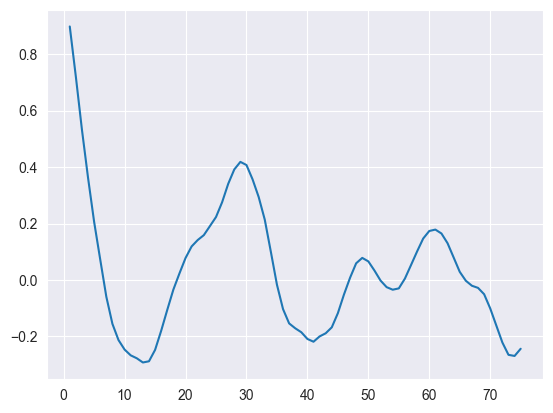

In [134]:
r2_m = r2.resample("ME").mean().dropna()

# autocorrelation up to 60 months
acf = pd.Series([r2_m.autocorr(lag=i) for i in range(1, 76)], index=range(1, 76))

print("Top ACF lags:")
print(acf.sort_values(ascending=False).head(10))

# crude "dominant period" = lag with max positive acf
dominant_lag = int(acf.idxmax())
print("Dominant lag (months):", dominant_lag)

x = (r2_m - r2_m.mean()).to_numpy()
n = len(x)
freq = np.fft.rfftfreq(n, d=1.0)          # cycles per month
spec = np.abs(np.fft.rfft(x))**2

# ignore zero-frequency
freq, spec = freq[1:], spec[1:]
best = np.argmax(spec)
period_months = 1.0 / freq[best]

print("Strongest period (months):", period_months)

acf.plot()

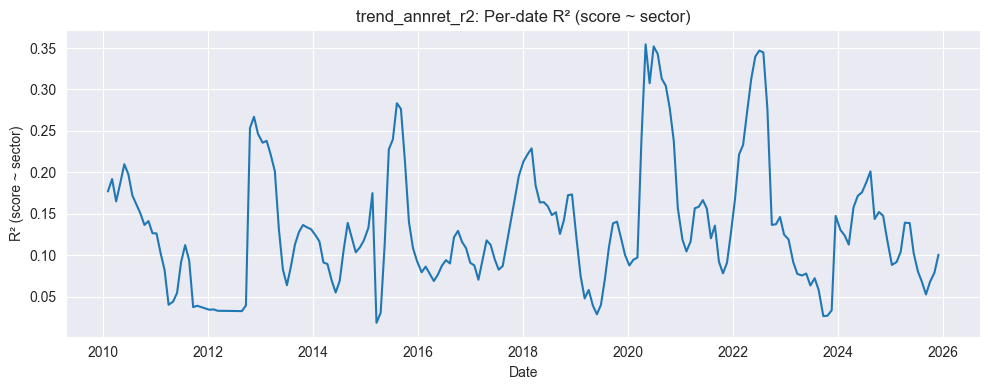


=== 2×2 Conditional Comparison (RAW vs Neutralised) ===
         Model                  Condition  Ann Return (geo)  Ann Vol  Sharpe  \
0          Raw   R²_sector LOW (<= 0.075)             21.21    24.96   0.850   
1  Neutralised   R²_sector LOW (<= 0.075)              6.94    16.79   0.413   
2          Raw  R²_sector HIGH (>= 0.176)             31.28    23.80   1.314   
3  Neutralised  R²_sector HIGH (>= 0.176)             16.83    14.61   1.152   

   Max DD   N  
0  -32.23  41  
1  -16.69  41  
2  -15.60  41  
3  -11.94  41  


In [136]:
# ============================================================
# Task 1) Plot per-date R^2 (sector only): score ~ sector
# Task 2) 2×2 conditional comparison:
#         Condition: R^2_sector high (>80% q) vs low (<20% q)
#         Compare: raw L/S vs neutralised L/S performance (same dates)
#
# Requirements:
# - You already have `results` dict with reps:
#     results["trend_annret_r2"] and results["trend_annret_r2 Neutralised"]
#     (same structure for other signals)
# - You also still have the raw signal score DataFrame used to build the rep:
#     `sig_scores_rb` = signal scores on rebalance dates (date x ticker)
# - You have:
#     hsci_sector_map["sector"] : ticker -> sector
#     universe_eligible (date x ticker bool) and/or elig_rb aligned to rebalance dates
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers ----------

def get_rebalance_dates_from_rep(rep: dict) -> pd.DatetimeIndex:
    if "ls_ret" in rep and rep["ls_ret"] is not None:
        return pd.to_datetime(rep["ls_ret"].index)
    raise KeyError("rep missing 'ls_ret'")

def _as_series(x, name=None):
    if isinstance(x, pd.Series):
        s = x.copy()
    else:
        s = pd.Series(x)
    if name is not None:
        s.name = name
    s = s.dropna()
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index)
    return s.sort_index()

def ret_to_equity(ret: pd.Series) -> pd.Series:
    ret = ret.dropna().sort_index()
    eq = (1.0 + ret).cumprod()
    eq.name = "eq"
    return eq

def perf_stats_from_returns(ret: pd.Series, freq_per_year: float = 12.6):
    """
    Compute simple performance stats:
    - ann_return_geo: geometric annualised return
    - ann_vol: annualised volatility (sqrt(freq)*std)
    - sharpe: ann_return / ann_vol (rf=0)
    - max_dd: max drawdown from equity
    """
    ret = ret.dropna().sort_index()
    if len(ret) < 3:
        return {"ann_return_geo": np.nan, "ann_vol": np.nan, "sharpe": np.nan, "max_dd": np.nan, "n_obs": len(ret)}

    eq = ret_to_equity(ret)
    n = len(ret)
    years = n / freq_per_year
    ann_return_geo = float(eq.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else np.nan

    ann_vol = float(ret.std(ddof=0) * np.sqrt(freq_per_year))
    sharpe = float(ann_return_geo / ann_vol) if ann_vol > 0 else np.nan

    peak = eq.cummax()
    dd = eq / peak - 1.0
    max_dd = float(dd.min())

    return {"ann_return_geo": ann_return_geo, "ann_vol": ann_vol, "sharpe": sharpe, "max_dd": max_dd, "n_obs": n}

# ---------- (1) Sector-only R^2 per date ----------
def r2_sector_only(scores_rb: pd.DataFrame,
                   sector_map: pd.Series,
                   elig_rb: pd.DataFrame,
                   min_assets: int = 50) -> pd.Series:
    dates = pd.to_datetime(scores_rb.index)
    tickers = scores_rb.columns
    sec_df = sector_series_to_df(sector_map, dates, tickers)

    out = {}
    for d in dates:
        y = scores_rb.loc[d]
        s = sec_df.loc[d]
        m = elig_rb.loc[d].reindex(tickers).fillna(False).astype(bool) & y.notna() & s.notna()
        if int(m.sum()) < min_assets:
            out[d] = np.nan
            continue

        yv = y[m].to_numpy(dtype=float)
        sec = s[m].astype("category")

        y_bar = yv.mean()
        sst = float(((yv - y_bar) ** 2).sum())
        if sst <= 0:
            out[d] = np.nan
            continue

        codes = sec.cat.codes.to_numpy()
        sum_y = np.bincount(codes, weights=yv)
        cnt = np.bincount(codes)
        mean_y = sum_y / np.where(cnt == 0, np.nan, cnt)

        y_t = yv - mean_y[codes]   # residual after sector
        sse = float((y_t * y_t).sum())

        out[d] = 1.0 - sse / sst

    return pd.Series(out).sort_index()

def plot_r2_sector_only(r2_sec: pd.Series, title: str):
    r2_sec = _as_series(r2_sec, "r2_sec")
    plt.figure(figsize=(10, 4))
    plt.plot(r2_sec.index, r2_sec.values)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("R² (score ~ sector)")
    plt.tight_layout()
    plt.show()

# ---------- (2) 2×2 conditional comparison: High vs Low R2 sector ----------
def conditional_2x2_raw_vs_neu(
    rep_raw: dict,
    rep_neu: dict,
    r2_sec: pd.Series,
    q_low: float = 0.20,
    q_high: float = 0.80,
):
    """
    Uses rep["ls_ret"] returns series; selects dates based on r2_sec quantiles; computes stats.
    """
    ret_raw = _as_series(rep_raw["ls_ret"], "ret_raw")
    ret_neu = _as_series(rep_neu["ls_ret"], "ret_neu")
    r2_sec = _as_series(r2_sec, "r2_sec")

    # align on common rebalance dates
    idx = ret_raw.index.intersection(ret_neu.index).intersection(r2_sec.index)
    ret_raw = ret_raw.reindex(idx)
    ret_neu = ret_neu.reindex(idx)
    r2_sec = r2_sec.reindex(idx)

    lo_thr = float(r2_sec.quantile(q_low))
    hi_thr = float(r2_sec.quantile(q_high))

    mask_low = r2_sec <= lo_thr
    mask_high = r2_sec >= hi_thr

    freq = float(rep_raw.get("meta", {}).get("freq_per_year", 12.6))

    def _row(label, r):
        st = perf_stats_from_returns(r, freq_per_year=freq)
        return {
            "Condition": label,
            "Ann Return (geo)": st["ann_return_geo"],
            "Ann Vol": st["ann_vol"],
            "Sharpe": st["sharpe"],
            "Max DD": st["max_dd"],
            "N": st["n_obs"],
        }

    out = []
    out.append({"Model": "Raw", **_row(f"R²_sector LOW (<= {lo_thr:.3f})", ret_raw[mask_low])})
    out.append({"Model": "Neutralised", **_row(f"R²_sector LOW (<= {lo_thr:.3f})", ret_neu[mask_low])})
    out.append({"Model": "Raw", **_row(f"R²_sector HIGH (>= {hi_thr:.3f})", ret_raw[mask_high])})
    out.append({"Model": "Neutralised", **_row(f"R²_sector HIGH (>= {hi_thr:.3f})", ret_neu[mask_high])})

    df = pd.DataFrame(out)

    # pretty formatting
    df_fmt = df.copy()
    for c in ["Ann Return (geo)", "Ann Vol", "Max DD"]:
        df_fmt[c] = (df_fmt[c] * 100.0).round(2)
    df_fmt["Sharpe"] = df_fmt["Sharpe"].round(3)

    return df, df_fmt

# ============================================================
# RUN for ONE signal (example: trend)
# ============================================================
signal_name = "trend_annret_r2"

rep_raw = results[signal_name]
rep_neu = results[f"{signal_name} Neutralised"]

# Rebalance dates (must match your sig_scores_rb and elig_rb)
rebal_dates = get_rebalance_dates_from_rep(rep_raw)

# You need scores on rebalance dates:
sig_scores_rb = sig_scores.reindex(index=rebal_dates)   # date x ticker

# ---- plug your existing objects here ----
scores_rb = sig_scores_rb  # <- set this in your notebook
elig_rb = universe_eligible.reindex(index=rebal_dates, columns=scores_rb.columns).fillna(False).astype(bool)

# 1) sector-only R^2
r2_sec = r2_sector_only(
    scores_rb=scores_rb,
    sector_map=hsci_sector_map["sector"],
    elig_rb=elig_rb,
    min_assets=50,
)

plot_r2_sector_only(r2_sec, title=f"{signal_name}: Per-date R² (score ~ sector)")


# 2) 2×2 conditional comparison
df_raw, df_pretty = conditional_2x2_raw_vs_neu(rep_raw, rep_neu, r2_sec, q_low=0.20, q_high=0.80)

print("\n=== 2×2 Conditional Comparison (RAW vs Neutralised) ===")
print(df_pretty)


Top ACF lags:
1     0.866431
2     0.651340
3     0.441623
4     0.271920
22    0.238932
23    0.231620
30    0.230714
28    0.226001
29    0.221587
27    0.213628
dtype: float64
Dominant lag (months): 1
Strongest period (months): 27.142857142857146
plateau_mean(22-32): 0.21326840195991545 CI: 0.14219334502156228
acf(15): -0.3561217713147652 acf(38): -0.310481180721166


<Axes: title={'center': 'ACF Plot'}>

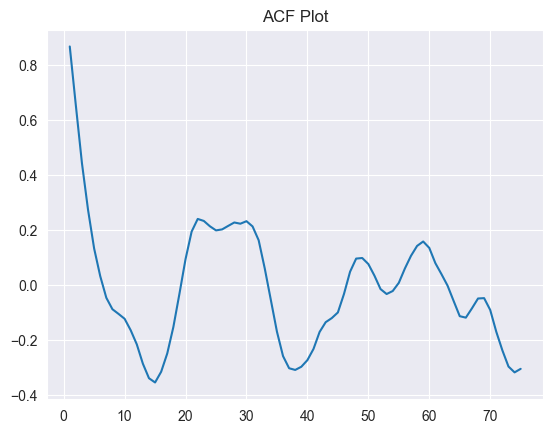

In [137]:
r2_m = r2_sec.resample("ME").mean().dropna()

# autocorrelation up to 60 months
acf = pd.Series([r2_m.autocorr(lag=i) for i in range(1, 76)], index=range(1, 76))

print("Top ACF lags:")
print(acf.sort_values(ascending=False).head(10))

# crude "dominant period" = lag with max positive acf
dominant_lag = int(acf.idxmax())
print("Dominant lag (months):", dominant_lag)

x = (r2_m - r2_m.mean()).to_numpy()
n = len(x)
freq = np.fft.rfftfreq(n, d=1.0)          # cycles per month
spec = np.abs(np.fft.rfft(x))**2

# ignore zero-frequency
freq, spec = freq[1:], spec[1:]
best = np.argmax(spec)
period_months = 1.0 / freq[best]

print("Strongest period (months):", period_months)

plateau = acf[21:32]   # 22..32
plateau_mean = np.nanmean(plateau)

val_15 = acf[15]
val_38 = acf[38]

ci = 1.96 / np.sqrt(190)

print("plateau_mean(22-32):", plateau_mean, "CI:", ci)
print("acf(15):", val_15, "acf(38):", val_38)
acf.plot(title='ACF Plot')

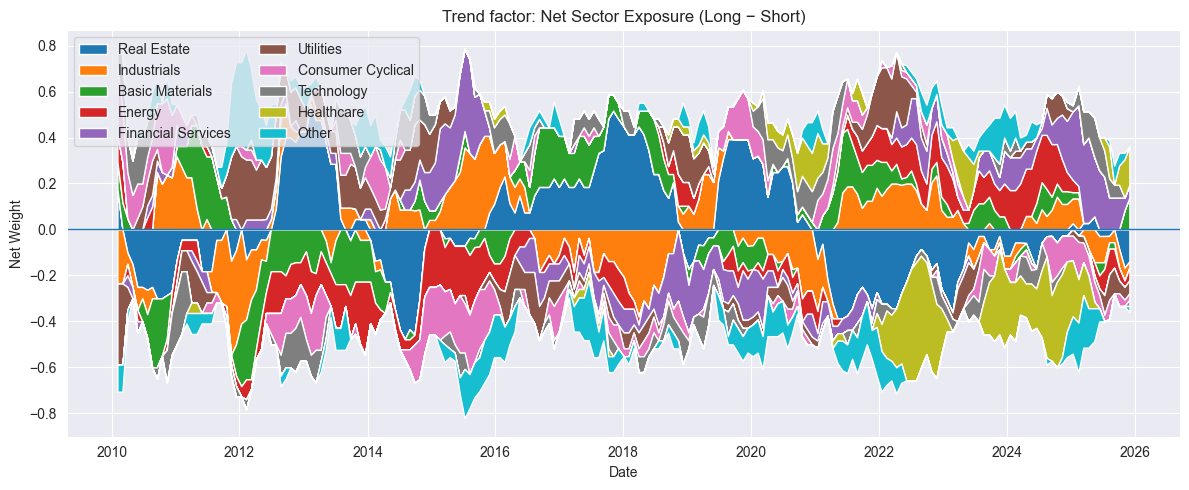

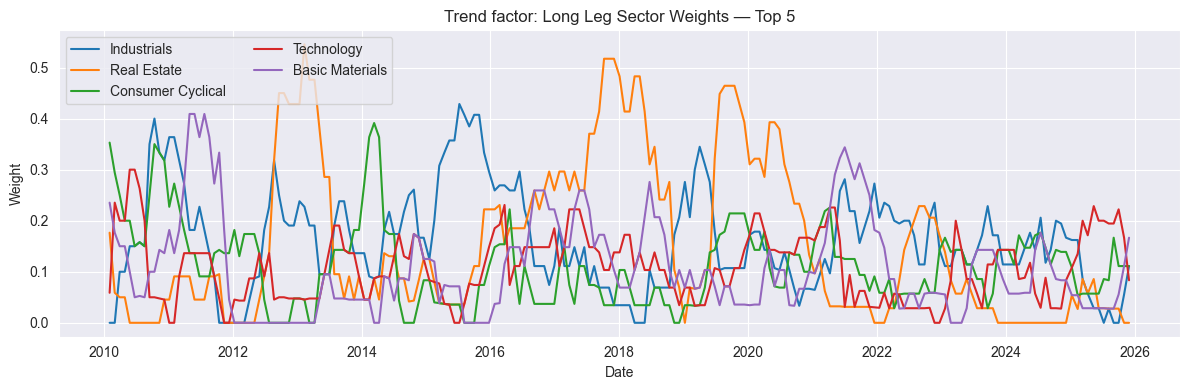

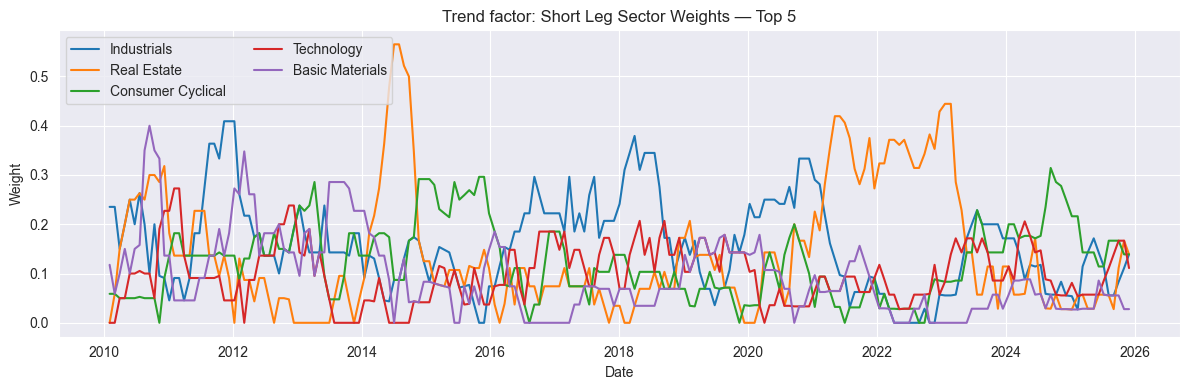

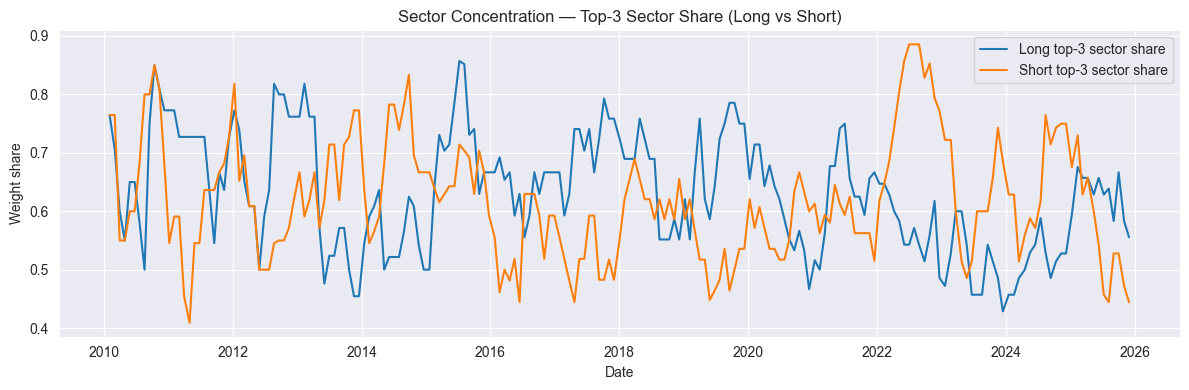

In [141]:
# -----------------------
# Inputs (from your earlier run)
# sec_exp = compute_sector_exposure(...)
# sec_exp["long_w"]    : DataFrame index=date, columns=sector, values=weights (sum=1)
# sec_exp["short_w"]   : DataFrame index=date, columns=sector, values=weights (sum=1)
# sec_exp["universe_w"]: optional
# -----------------------

long_w = sec_exp["long_w"].copy()
short_w = sec_exp["short_w"].copy()

# Ensure aligned dates & sectors
idx = long_w.index.intersection(short_w.index)
cols = long_w.columns.union(short_w.columns)
long_w = long_w.reindex(index=idx, columns=cols).fillna(0.0)
short_w = short_w.reindex(index=idx, columns=cols).fillna(0.0)

# Net exposure = Long - Short (can be negative)
net_w = long_w - short_w

# Optional: drop "UNKOWN" or rename
net_w = net_w.drop(columns=["UNKOWN"], errors="ignore")
long_w = long_w.drop(columns=["UNKOWN"], errors="ignore")
short_w = short_w.drop(columns=["UNKOWN"], errors="ignore")

def plot_net_sector_stacked_area(net_w: pd.DataFrame, top_k: int = 8, title: str = ""):
    """
    Net sector exposure (Long-Short) stacked area.
    Positive and negative parts are stacked separately.
    """
    df_all = net_w.copy()

    # pick top_k by mean absolute net exposure
    top = df_all.abs().mean().sort_values(ascending=False).head(top_k).index
    df = df_all.reindex(columns=top).copy()

    # group remaining sectors into "Other"
    other = df_all.drop(columns=top, errors="ignore").sum(axis=1)
    df["Other"] = other

    # split into positive and negative parts
    pos = df.clip(lower=0.0)
    neg = df.clip(upper=0.0)

    plt.figure(figsize=(12, 5))

    # positive stack (with labels)
    plt.stackplot(pos.index, pos.T.values, labels=pos.columns)

    # negative stack (NO labels -> avoids NoneType iterable error)
    plt.stackplot(neg.index, neg.T.values)

    plt.axhline(0.0, linewidth=1)
    plt.title(title or f"Net Sector Exposure (Long − Short) — Top {top_k} + Other")
    plt.xlabel("Date")
    plt.ylabel("Net Weight")
    plt.legend(loc="upper left", ncol=2)
    plt.tight_layout()
    plt.show()

def plot_long_short_topk_lines(long_w: pd.DataFrame, short_w: pd.DataFrame, top_k: int = 6, title_prefix: str = ""):
    """
    Plot top_k sectors (by average weight) as lines for Long and Short separately.
    """
    # Long top sectors
    topL = long_w.mean().sort_values(ascending=False).head(top_k).index
    plt.figure(figsize=(12, 4))
    for c in topL:
        plt.plot(long_w.index, long_w[c], label=c)
    plt.title(title_prefix + f"Long Leg Sector Weights — Top {top_k}")
    plt.xlabel("Date")
    plt.ylabel("Weight")
    plt.legend(loc="upper left", ncol=2)
    plt.tight_layout()
    plt.show()

    # Short top sectors
    topS = short_w.mean().sort_values(ascending=False).head(top_k).index
    plt.figure(figsize=(12, 4))
    for c in topS:
        plt.plot(short_w.index, short_w[c], label=c)
    plt.title(title_prefix + f"Short Leg Sector Weights — Top {top_k}")
    plt.xlabel("Date")
    plt.ylabel("Weight")
    plt.legend(loc="upper left", ncol=2)
    plt.tight_layout()
    plt.show()

def plot_sector_concentration(long_w: pd.DataFrame, short_w: pd.DataFrame, k: int = 3):
    """
    Plot concentration metrics: top-k sector weight share over time for Long and Short.
    Useful to detect regime crowding.
    """
    def topk_share(df):
        return df.apply(lambda row: row.sort_values(ascending=False).head(k).sum(), axis=1)

    long_topk = topk_share(long_w)
    short_topk = topk_share(short_w)

    plt.figure(figsize=(12, 4))
    plt.plot(long_topk.index, long_topk.values, label=f"Long top-{k} sector share")
    plt.plot(short_topk.index, short_topk.values, label=f"Short top-{k} sector share")
    plt.title(f"Sector Concentration — Top-{k} Sector Share (Long vs Short)")
    plt.xlabel("Date")
    plt.ylabel("Weight share")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------
# Run the plots
# -----------------------
plot_net_sector_stacked_area(net_w, top_k=9, title="Trend factor: Net Sector Exposure (Long − Short)")

plot_long_short_topk_lines(long_w, short_w, top_k=5, title_prefix="Trend factor: ")

plot_sector_concentration(long_w, short_w, k=3)

## Neutralisation Check

In [ ]:
import numpy as np
import pandas as pd

def sector_series_to_df(sector: pd.Series, dates, tickers) -> pd.DataFrame:
    """Broadcast ticker->sector to date x ticker"""
    s = sector.reindex(tickers)
    return pd.DataFrame(np.tile(s.to_numpy(), (len(dates), 1)), index=dates, columns=tickers)

def to_log_mcap(mcap: pd.DataFrame) -> pd.DataFrame:
    x = mcap.copy()
    x = x.where(x > 0)
    return np.log(x)

def _stack(df: pd.DataFrame, name: str) -> pd.Series:
    return df.stack(dropna=False).rename(name)

def _build_mask(y: pd.DataFrame, lnmcap: pd.DataFrame, sec_df: pd.DataFrame, elig: pd.DataFrame | None):
    if elig is None:
        elig = pd.DataFrame(True, index=y.index, columns=y.columns)
    else:
        elig = elig.reindex(index=y.index, columns=y.columns).fillna(False).astype(bool)
    mask = elig & y.notna() & lnmcap.notna() & sec_df.notna()
    return mask

# ---------- A) Neutralisation verification ----------
def neutralisation_checks(
    resid: pd.DataFrame,              # date x ticker (neutralised scores)
    sector: pd.Series,                # ticker -> sector
    mcap: pd.DataFrame,               # date x ticker (NOT logged)
    universe_eligible: pd.DataFrame | None = None,
) -> dict:
    dates, tickers = resid.index, resid.columns
    sec_df = sector_series_to_df(sector, dates, tickers)
    lnmcap = to_log_mcap(mcap.reindex(index=dates, columns=tickers))

    mask = _build_mask(resid, lnmcap, sec_df, universe_eligible)

    # A1) per-date corr(resid, ln(mcap))
    r = resid.where(mask)
    x = lnmcap.where(mask)
    corr_by_date = r.corrwith(x, axis=1, method="spearman")  # Spearman is typical for cross-section
    # If you want Pearson, change method="pearson"

    # A2) per-date per-sector mean(resid)
    # We'll compute sector means on the masked sample.
    # Implementation: stack -> groupby(date, sector) -> mean
    r_st = _stack(r, "resid")
    sec_st = _stack(sec_df.where(mask), "sector")
    df = pd.concat([r_st, sec_st], axis=1).dropna()

    # groupby date + sector
    sector_mean = df.groupby([df.index.get_level_values(0), "sector"])["resid"].mean()
    sector_mean = sector_mean.unstack("sector")  # date x sector

    # summary: max absolute sector mean per date (should be near 0)
    max_abs_sector_mean_by_date = sector_mean.abs().max(axis=1)

    return {
        "corr_resid_lnmcap_by_date": corr_by_date,
        "sector_mean_resid": sector_mean,  # date x sector
        "max_abs_sector_mean_by_date": max_abs_sector_mean_by_date,
        "mask_coverage_by_date": mask.mean(axis=1),  # fraction of tickers used per date
    }

# ---------- B) Exposure strength: per-date R^2 of score ~ sector + ln(mcap) ----------
def exposure_r2_by_date(
    scores: pd.DataFrame,             # date x ticker (RAW score, not neutralised)
    sector: pd.Series,                # ticker -> sector
    mcap: pd.DataFrame,               # date x ticker
    universe_eligible: pd.DataFrame | None = None,
    clip_lnmcap_q: float | None = 0.01,
    clip_score_q: float | None = None,   # optional, e.g. 0.01
) -> pd.Series:
    dates, tickers = scores.index, scores.columns
    sec_df = sector_series_to_df(sector, dates, tickers)
    lnmcap = to_log_mcap(mcap.reindex(index=dates, columns=tickers))

    # optional winsorize ln(mcap) per date
    if clip_lnmcap_q is not None and 0.0 < clip_lnmcap_q < 0.5:
        lo = lnmcap.quantile(clip_lnmcap_q, axis=1)
        hi = lnmcap.quantile(1.0 - clip_lnmcap_q, axis=1)
        lnmcap = lnmcap.clip(lower=lo, upper=hi, axis=0)

    y = scores.reindex(index=dates, columns=tickers)

    # optional winsorize score per date (often helps stability)
    if clip_score_q is not None and 0.0 < clip_score_q < 0.5:
        lo = y.quantile(clip_score_q, axis=1)
        hi = y.quantile(1.0 - clip_score_q, axis=1)
        y = y.clip(lower=lo, upper=hi, axis=0)

    mask = _build_mask(y, lnmcap, sec_df, universe_eligible)

    y_st = _stack(y.where(mask), "y")
    x_st = _stack(lnmcap.where(mask), "x")
    s_st = _stack(sec_df.where(mask), "sector")
    df = pd.concat([y_st, x_st, s_st], axis=1).dropna()

    date = df.index.get_level_values(0)

    # We'll compute R^2 per date via ANOVA identity using FWL:
    # R^2 = 1 - SSE/SST
    # where model includes sector dummies + x.
    # We'll do it efficiently:
    # 1) demean y by sector; demean x by sector (within each date)
    # 2) regress y_tilde ~ x_tilde => get SSE; then SST is var(y) around mean (within date) * n

    out_r2 = {}

    for d, g in df.groupby(date, sort=False):
        y_d = g["y"].to_numpy()
        x_d = g["x"].to_numpy()
        sec_d = g["sector"].astype("category")

        # overall mean for SST
        y_bar = y_d.mean()
        sst = ((y_d - y_bar) ** 2).sum()
        if sst <= 0:
            out_r2[d] = np.nan
            continue

        # sector means
        # compute sector index
        codes = sec_d.cat.codes.to_numpy()
        n = len(y_d)

        # means by sector
        # (vectorized accumulation)
        sum_y = np.bincount(codes, weights=y_d)
        cnt = np.bincount(codes)
        mean_y = sum_y / np.where(cnt == 0, np.nan, cnt)

        sum_x = np.bincount(codes, weights=x_d)
        mean_x = sum_x / np.where(cnt == 0, np.nan, cnt)

        # residualize by sector
        y_t = y_d - mean_y[codes]
        x_t = x_d - mean_x[codes]

        # beta = (x_t'y_t)/(x_t'x_t)
        den = (x_t * x_t).sum()
        if den <= 0:
            # model reduces to sector-only; compute SSE = sum(y_t^2)
            sse = (y_t * y_t).sum()
        else:
            beta = (x_t * y_t).sum() / den
            resid = y_t - beta * x_t
            sse = (resid * resid).sum()

        r2 = 1.0 - sse / sst
        out_r2[d] = r2

    r2_by_date = pd.Series(out_r2).sort_index()
    return r2_by_date

# A) Neutralisation checks
chk = neutralisation_checks(
    resid=neu_sec_and_mktcap,
    sector=hsci_sector_map['sector'],
    mcap=mcap,
    universe_eligible=universe_eligible,   # or None
)

corr_by_date = chk["corr_resid_lnmcap_by_date"]
max_abs_sec_mean = chk["max_abs_sector_mean_by_date"]
sector_mean_table = chk["sector_mean_resid"]

print(corr_by_date.describe())
print(max_abs_sec_mean.describe())

# B) Exposure strength R^2
r2 = exposure_r2_by_date(
    scores=sig,
    sector=hsci_sector_map['sector'],
    mcap=mcap,
    universe_eligible=universe_eligible,
    clip_lnmcap_q=0.01,
    clip_score_q=0.01,   # optional
)

print(r2.describe())


In [ ]:
def neutralize_sector_and_mcap_fwl(
    scores: pd.DataFrame,
    sector: pd.Series,                # ticker -> sector
    mcap: pd.DataFrame,               # date x ticker (NOT logged)
    universe_eligible: pd.DataFrame = None,
    clip_lnmcap_q: float = 0.01,
) -> pd.DataFrame:
    dates, tickers = scores.index, scores.columns

    # --- align inputs ---
    y = scores.reindex(index=dates, columns=tickers)
    sec_df = sector_series_to_df(sector, dates, tickers)
    lnmcap = to_log_mcap(mcap.reindex(index=dates, columns=tickers))

    if universe_eligible is None:
        elig = pd.DataFrame(True, index=dates, columns=tickers)
    else:
        elig = universe_eligible.reindex(index=dates, columns=tickers).fillna(False).astype(bool)

    # optional clip lnmcap (ok)
    if clip_lnmcap_q is not None and 0.0 < clip_lnmcap_q < 0.5:
        lo = lnmcap.quantile(clip_lnmcap_q, axis=1)
        hi = lnmcap.quantile(1.0 - clip_lnmcap_q, axis=1)
        lnmcap = lnmcap.clip(lower=lo, upper=hi, axis=0)

    # IMPORTANT: enforce the final sample BEFORE neutralisation
    mask = elig & y.notna() & lnmcap.notna() & sec_df.notna()
    y = y.where(mask)
    lnmcap = lnmcap.where(mask)
    sec_df = sec_df.where(mask)

    # sector residualize on the same sample
    y_tilde = neutralize_sector(y, sec_df)
    x_tilde = neutralize_sector(lnmcap, sec_df)

    # stack (no dropna needed now if mask is correct, but harmless)
    df = pd.concat([_stack(y_tilde, "y"), _stack(x_tilde, "x")], axis=1).dropna()

    date = df.index.get_level_values(0)
    g = df.groupby(date, sort=False)

    # No extra date demeaning needed (FWL already handled intercept via sector projection)
    num = (df["x"] * df["y"]).groupby(date, sort=False).sum()
    den = (df["x"] * df["x"]).groupby(date, sort=False).sum().replace(0.0, np.nan)
    beta = num / den

    beta_row = beta.reindex(date).to_numpy(dtype=float)
    resid = df["y"].to_numpy(dtype=float) - beta_row * df["x"].to_numpy(dtype=float)

    out = pd.Series(resid, index=df.index, name="resid").unstack()
    out = out.reindex(index=dates, columns=tickers)
    
    lnmcap_used = lnmcap.where(mask)
    return out, lnmcap_used

sig = compute_signal(md, name="trend_annret_r2", lookback=252, ann_factor=252, skip=21)
sig = sig.reindex(index=md.close.index, columns=md.close.columns)

neu_sec_and_mktcap, lnmcap_used = neutralize_sector_and_mcap_fwl(sig, hsci_sector_map['sector'], hsci_market_cap, universe_eligible)

rep_neu = make_tearsheet(
    md=md,
    signal=neu_sec_and_mktcap,
    H=20,
    n_buckets=10,
    entry_mode="next_close",
    min_assets_ic=50,
    plot=False,
    benchmark_price=hsi,
    benchmark_name="^HSI",
    universe_eligible=universe_eligible,  # critical
)

In [22]:
corr_by_date = neu_sec_and_mktcap.corrwith(lnmcap_used, axis=1, method="spearman")
print(corr_by_date.describe())

count    4082.000000
mean       -0.025922
std         0.201314
min        -0.851592
25%        -0.070020
50%        -0.023969
75%         0.017069
max         0.591474
dtype: float64


In [23]:
resid = neu_sec_and_mktcap 

corr = corr_by_date  # 你刚算出来的 Series
n_eff = resid.notna().sum(axis=1)  # 或用你 neutralisation 用过的 mask.sum(axis=1)

out = pd.DataFrame({"corr": corr, "abs_corr": corr.abs(), "n_eff": n_eff})
print(out.sort_values("abs_corr", ascending=False).head(20))
print(out.groupby(pd.qcut(out["n_eff"], 5))["abs_corr"].describe())


                corr  abs_corr  n_eff
Date                                 
2012-03-07 -0.851592  0.851592    232
2012-03-13 -0.851131  0.851131    232
2012-03-05 -0.851048  0.851048    231
2012-03-08 -0.850808  0.850808    232
2012-03-06 -0.850755  0.850755    232
2012-03-09 -0.850364  0.850364    232
2012-03-15 -0.850215  0.850215    232
2012-03-14 -0.850081  0.850081    232
2012-03-12 -0.849616  0.849616    232
2012-03-23 -0.849409  0.849409    231
2012-03-16 -0.849235  0.849235    232
2012-03-19 -0.849235  0.849235    232
2012-03-21 -0.848923  0.848923    232
2012-03-26 -0.848791  0.848791    231
2012-03-22 -0.848766  0.848766    232
2012-03-28 -0.848375  0.848375    230
2012-03-20 -0.848015  0.848015    232
2012-03-29 -0.847929  0.847929    230
2012-03-27 -0.847468  0.847468    231
2012-03-30 -0.847197  0.847197    230
                 count      mean       std       min       25%       50%  \
n_eff                                                                      
(-0.001, 221

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_75957/1405959937.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(out.groupby(pd.qcut(out["n_eff"], 5))["abs_corr"].describe())


In [26]:
corr_pearson = resid.corrwith(lnmcap_used, axis=1, method="pearson")
print(corr_pearson.describe())

# Compare on the problematic dates
bad_dates = out.sort_values("abs_corr", ascending=False).head(20).index
print(pd.DataFrame({
    "spearman": resid.corrwith(lnmcap_used, axis=1, method="spearman").reindex(bad_dates),
    "pearson":  resid.corrwith(lnmcap_used, axis=1, method="pearson").reindex(bad_dates),
    "n_eff":    n_eff.reindex(bad_dates),
}))


# x_tilde is ln(mcap) residualised by sector on the same mask
x_tilde = neutralize_sector(lnmcap_used, sector_df)  # use the same sec_df/mask you used in neutralisation
x_var = x_tilde.var(axis=1, skipna=True)

tmp = pd.DataFrame({"abs_spearman": out["abs_corr"], "abs_pearson": corr_pearson.abs(), "x_var": x_var, "n_eff": n_eff})
print(tmp.loc[bad_dates].sort_values("x_var").head(20))


count    4.082000e+03
mean     2.027635e-19
std      3.165350e-17
min     -1.741392e-16
25%     -1.664135e-17
50%      0.000000e+00
75%      1.684300e-17
max      1.638263e-16
dtype: float64
            spearman       pearson  n_eff
Date                                     
2012-03-07 -0.851592 -1.450065e-17    232
2012-03-13 -0.851131  2.290143e-17    232
2012-03-05 -0.851048 -3.302828e-17    231
2012-03-08 -0.850808  0.000000e+00    232
2012-03-06 -0.850755 -7.709742e-18    232
2012-03-09 -0.850364 -2.571867e-17    232
2012-03-15 -0.850215  2.051692e-17    232
2012-03-14 -0.850081  0.000000e+00    232
2012-03-12 -0.849616  0.000000e+00    232
2012-03-23 -0.849409 -2.284987e-17    231
2012-03-16 -0.849235  9.715018e-18    232
2012-03-19 -0.849235 -9.232853e-18    232
2012-03-21 -0.848923 -8.342933e-18    232
2012-03-26 -0.848791 -7.297654e-18    231
2012-03-22 -0.848766  0.000000e+00    232
2012-03-28 -0.848375 -2.012893e-17    230
2012-03-20 -0.848015 -8.767680e-18    232
2012-03-29 